# FineST in CRC Visium HD data

## Main steps

- Step1: Prepare paired image patch and ST spot: Align image pixels with bin coordinates
- Step2: Train the model on 80% data and test on 20% data, on 16um-bin Visium HD dataset
- Step3: Infer sub-bin gene expression using trained model and impute using measured bins

In [1]:
import os
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import json
print(torch.__version__)

import FineST as fst
from FineST.datasets import dataset
import FineST.plottings as fstplt
print("FineST version: %s" %fst.__version__)

1.7.1


If use the local FineST packages

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
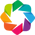

In [2]:
# ## From GPU2
# path = '/mnt/lingyu/nfs_share2/Python/'
# os.chdir(str(path) + 'FineST/FineST/')
# import FineST as fst
# from FineST.datasets import dataset
# import FineST.plottings as fstplt

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
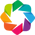

In [70]:
# import importlib
# import sys
# sys.path.append(str(path)+'FineST/FineST/')
# import FineST as fst
# import FineST.plottings
# importlib.reload(FineST.plottings)
# from FineST.plottings import *
# import FineST.plottings as fstplt

In [3]:
path = '/mnt/lingyu/nfs_share2/Python/'

fst.setup_seed(666)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

colors = ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"]
cnt_color = clr.LinearSegmentedColormap.from_list('magma', colors, N=256)

In [4]:
logging.getLogger().setLevel(logging.INFO)

model_folder = str(path) + 'FineST/FineST_local/Finetune/'
dir_name = model_folder + datetime.now().strftime('%Y%m%d%H%M%S%f')
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    logger = fst.setup_logger(dir_name)

print(dir_name)

/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20241116211723850793


## Load parameters

In [5]:
parameter_file_path = str(path) + 'FineST/FineST_local/Parameter/parameters_CRC16_0502.json'
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

logger.info("Load parameters:\n" + json.dumps(params, indent=2))

[2024-11-16 21:17:23] INFO - Load parameters:
{
  "n_encoder_hidden_matrix": 256,
  "n_encoder_hidden_image": 128,
  "n_encoder_latent": 128,
  "n_projection_hidden": 256,
  "n_projection_output": 128,
  "batch_size": 200,
  "batch_size_pair": 640,
  "n_encoder_layers": 2,
  "dropout_rate": 0,
  "training_epoch": 50,
  "inital_learning_rate": 0.1,
  "k_nearest_positives": 0,
  "temperature": 0.03
}


## 1. Load Spatial and Image data

1.1 Load spatial data

In [6]:
adata = dataset.CRC16um()
print(adata)

AnnData object with n_obs × n_vars = 137051 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


1.2 Selected LR genes 

In [7]:
LR_gene_path = str(path)+'FineST/FineST/Dataset/LRgene/LRgene_CellChatDB_baseline.csv'
adata = fst.adata_LR(adata, LR_gene_path)
adata

AnnData object with n_obs × n_vars = 137051 × 864
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

1.3 Data preprocess

In [8]:
adata = fst.adata_preprocess(adata)
print(adata)

AnnData object with n_obs × n_vars = 137051 × 862
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


In [9]:
gene_hv = np.array(adata.var_names)
print("gene_hv length:", len(gene_hv))

gene_hv length: 862


In [10]:
matrix = fst.adata2matrix(adata, gene_hv)
matrix

(137051, 862)


TGFB1    TGFBR1    TGFBR2  TGFB2  TGFB3  ACVR1B  \
                                                                         
s_016um_00052_00082-1    0.0  0.000000  0.000000    0.0    0.0     0.0   
s_016um_00010_00367-1    0.0  1.014055  0.000000    0.0    0.0     0.0   
s_016um_00163_00399-1    0.0  0.000000  0.504747    0.0    0.0     0.0   
s_016um_00238_00388-1    0.0  0.000000  0.000000    0.0    0.0     0.0   
s_016um_00144_00175-1    0.0  0.000000  0.000000    0.0    0.0     0.0   
...                      ...       ...       ...    ...    ...     ...   
s_016um_00375_00231-1    0.0  0.902664  0.397918    0.0    0.0     0.0   
s_016um_00109_00223-1    0.0  0.000000  0.000000    0.0    0.0     0.0   
s_016um_00039_00175-1    0.0  0.000000  0.000000    0.0    0.0     0.0   
s_016um_00037_00193-1    0.0  0.000000  2.847812    0.0    0.0     0.0   
s_016um_00144_00329-1    0.0  0.000000  0.000000    0.0    0.0     0.0   

                       ACVR1C     ACVR1      BMP2  BMPR1A  ...  TREM2  \
                                                           ...          
s_016um_00052_00082-1     0.0  0.000000  0.000000     0.0  ...    0.0   
s_016um_00010_00367-1     0.0  0.000000  0.000000     0.0  ...    0.0   
s_016um_00163_00399-1     0.0  0.504747  0.000000     0.0  ...    0.0   
s_016um_00238_00388-1     0.0  0.000000  0.000000     0.0  ...    0.0   
s_016um_00144_00175-1     0.0  0.000000  0.000000     0.0  ...    0.0   
...                       ...       ...       ...     ...  ...    ...   
s_016um_00375_00231-1     0.0  0.000000  0.681805     0.0  ...    0.0   
s_016um_00109_00223-1     0.0  0.000000  0.000000     0.0  ...    0.0   
s_016um_00039_00175-1     0.0  0.000000  0.000000     0.0  ...    0.0   
s_016um_00037_00193-1     0.0  0.000000  0.000000     0.0  ...    0.0   
s_016um_00144_00329-1     0.0  0.000000  0.000000     0.0  ...    0.0   

                         SEMA6A  SEMA6B  SEMA7A  PLXNC1   SIGLEC1  THY1  \
                                                                          
s_016um_00052_00082-1  0.000000     0.0     0.0     0.0  0.000000   0.0   
s_016um_00010_00367-1  0.000000     0.0     0.0     0.0  0.000000   0.0   
s_016um_00163_00399-1  0.000000     0.0     0.0     0.0  0.000000   0.0   
s_016um_00238_00388-1  0.000000     0.0     0.0     0.0  0.000000   0.0   
s_016um_00144_00175-1  0.000000     0.0     0.0     0.0  0.000000   0.0   
...                         ...     ...     ...     ...       ...   ...   
s_016um_00375_00231-1  0.000000     0.0     0.0     0.0  0.000000   0.0   
s_016um_00109_00223-1  0.997143     0.0     0.0     0.0  0.000000   0.0   
s_016um_00039_00175-1  0.000000     0.0     0.0     0.0  1.573506   0.0   
s_016um_00037_00193-1  0.000000     0.0     0.0     0.0  0.000000   0.0   
s_016um_00144_00329-1  0.000000     0.0     0.0     0.0  0.000000   0.0   

                          VCAM1  VSIR  IGSF11  
                                               
s_016um_00052_00082-1  0.000000   0.0     0.0  
s_016um_00010_00367-1  0.000000   0.0     0.0  
s_016um_00163_00399-1  0.504747   0.0     0.0  
s_016um_00238_00388-1  0.000000   0.0     0.0  
s_016um_00144_00175-1  0.000000   0.0     0.0  
...                         ...   ...     ...  
s_016um_00375_00231-1  0.000000   0.0     0.0  
s_016um_00109_00223-1  0.000000   0.0     0.0  
s_016um_00039_00175-1  0.000000   0.0     0.0  
s_016um_00037_00193-1  0.000000   0.0     0.0  
s_016um_00144_00329-1  0.000000   0.0     0.0  

[137051 rows x 862 columns]

1.4 Order by image file name

In [11]:
## Load image embedding from HIPT
file_paths = sorted(os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/HD_CRC_16um_pth_32_16/'))
print("Image embedding file:", file_paths[:3])

Image embedding file: ['HD_CRC_16um_40624.27653892974_22352.72327885696.pth', 'HD_CRC_16um_40625.065571800296_22294.29475902266.pth', 'HD_CRC_16um_40625.85460213809_22235.866426741108.pth']


In [12]:
df = fst.get_image_coord(file_paths, dataset_class="VisiumHD")
print(df.shape)
print(df.head())

(136954, 2)
              pixel_x             pixel_y
0   22352.72327885696   40624.27653892974
1   22294.29475902266  40625.065571800296
2  22235.866426741108   40625.85460213809
3    22177.4382820114   40626.64362994314
4   22119.01032483262   40627.43265521545


In [13]:
## Read ST bin position in '.parquet' format
patientxy = 'CRC16um'
position_path = str(path)+'FineST/FineST_local/Dataset/'+str(patientxy)+"/spatial/"
position_tissue = fst.parquet2csv(position_path)
position_tissue

## save .csv file
# position_tissue.to_csv("tissue_positions_"+str(patientxy)+".csv") 

in_tissue  array_row  array_col  pxl_col_in_fullres  \
barcode                                                                      
s_016um_00000_00000-1          1          0          0        22352.723279   
s_016um_00000_00001-1          1          0          1        22353.507390   
s_016um_00000_00002-1          1          0          2        22354.291503   
s_016um_00000_00003-1          1          0          3        22355.075617   
s_016um_00000_00007-1          1          0          7        22358.212091   
...                          ...        ...        ...                 ...   
s_016um_00391_00254-1          1        391        254         -285.338795   
s_016um_00391_00255-1          1        391        255         -284.577975   
s_016um_00418_00220-1          1        418        220        -1887.091347   
s_016um_00418_00221-1          1        418        221        -1886.332213   
s_016um_00418_00222-1          1        418        222        -1885.573079   

                       pxl_row_in_fullres  
barcode                                    
s_016um_00000_00000-1        40624.276539  
s_016um_00000_00001-1        40682.662627  
s_016um_00000_00002-1        40741.048834  
s_016um_00000_00003-1        40799.435159  
s_016um_00000_00007-1        41032.981648  
...                                   ...  
s_016um_00391_00254-1        55757.250510  
s_016um_00391_00255-1        55815.630416  
s_016um_00418_00220-1        53793.129171  
s_016um_00418_00221-1        53851.502537  
s_016um_00418_00222-1        53909.876021  

[137051 rows x 5 columns]

In [14]:
## Load ST bin position '.csv' format
patientxy = 'CRC16um'
os.chdir(str(path)+'FineST/FineST_local/Dataset/'+str(patientxy)+'/spatial/')
position = pd.read_csv('tissue_positions_square_016um.csv')
position

barcode  in_tissue  array_row  array_col  \
0       s_016um_00000_00000-1          1          0          0   
1       s_016um_00000_00001-1          1          0          1   
2       s_016um_00000_00002-1          1          0          2   
3       s_016um_00000_00003-1          1          0          3   
4       s_016um_00000_00007-1          1          0          7   
...                       ...        ...        ...        ...   
137046  s_016um_00391_00254-1          1        391        254   
137047  s_016um_00391_00255-1          1        391        255   
137048  s_016um_00418_00220-1          1        418        220   
137049  s_016um_00418_00221-1          1        418        221   
137050  s_016um_00418_00222-1          1        418        222   

        pxl_col_in_fullres  pxl_row_in_fullres  
0             22352.723279        40624.276539  
1             22353.507390        40682.662627  
2             22354.291503        40741.048834  
3             22355.075617        40799.435159  
4             22358.212091        41032.981648  
...                    ...                 ...  
137046         -285.338795        55757.250510  
137047         -284.577975        55815.630416  
137048        -1887.091347        53793.129171  
137049        -1886.332213        53851.502537  
137050        -1885.573079        53909.876021  

[137051 rows x 6 columns]

In [15]:
## merge position
position_image = fst.image_coord_merge(df, position, dataset='VisiumHD')
spotID_order = np.array(position_image['barcode'])
print(position_image.shape)
print(position_image.head())

(136954, 6)
                 barcode  in_tissue  x  y       pixel_x       pixel_y
0  s_016um_00000_00000-1          1  0  0  22352.723279  40624.276539
1  s_016um_00000_00001-1          1  0  1  22353.507390  40682.662627
2  s_016um_00000_00002-1          1  0  2  22354.291503  40741.048834
3  s_016um_00000_00003-1          1  0  3  22355.075617  40799.435159
4  s_016um_00000_00007-1          1  0  7  22358.212091  41032.981648


1.5 Order matrix row/barcode, spatial coordinates by image coordinates

In [16]:
matrix_order, matrix_order_df = fst.sort_matrix(matrix, position_image, spotID_order, gene_hv)
matrix_order_df

TGFB1  TGFBR1    TGFBR2  TGFB2  TGFB3  ACVR1B  ACVR1C  \
s_016um_00000_00000-1    0.0     0.0  1.341843    0.0    0.0     0.0     0.0   
s_016um_00000_00001-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   
s_016um_00000_00002-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   
s_016um_00000_00003-1    0.0     0.0  3.120895    0.0    0.0     0.0     0.0   
s_016um_00000_00007-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   
...                      ...     ...       ...    ...    ...     ...     ...   
s_016um_00385_00256-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   
s_016um_00385_00257-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   
s_016um_00385_00258-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   
s_016um_00385_00259-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   
s_016um_00385_00260-1    0.0     0.0  0.000000    0.0    0.0     0.0     0.0   

                       ACVR1  BMP2  BMPR1A  ...  TREM2  SEMA6A    SEMA6B  \
s_016um_00000_00000-1    0.0   0.0     0.0  ...    0.0     0.0  1.341843   
s_016um_00000_00001-1    0.0   0.0     0.0  ...    0.0     0.0  2.330756   
s_016um_00000_00002-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   
s_016um_00000_00003-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   
s_016um_00000_00007-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   
...                      ...   ...     ...  ...    ...     ...       ...   
s_016um_00385_00256-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   
s_016um_00385_00257-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   
s_016um_00385_00258-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   
s_016um_00385_00259-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   
s_016um_00385_00260-1    0.0   0.0     0.0  ...    0.0     0.0  0.000000   

                       SEMA7A  PLXNC1  SIGLEC1      THY1  VCAM1  VSIR  IGSF11  
s_016um_00000_00000-1     0.0     0.0      0.0  1.341843    0.0   0.0     0.0  
s_016um_00000_00001-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
s_016um_00000_00002-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
s_016um_00000_00003-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
s_016um_00000_00007-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
...                       ...     ...      ...       ...    ...   ...     ...  
s_016um_00385_00256-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
s_016um_00385_00257-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
s_016um_00385_00258-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
s_016um_00385_00259-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  
s_016um_00385_00260-1     0.0     0.0      0.0  0.000000    0.0   0.0     0.0  

[136954 rows x 862 columns]

In [17]:
## save gene expression mateix
# np.save(str(path)+'FineST/FineST_local/Dataset/CRC16um/ContrastCRC16geneLR/harmony_matrix.npy', matrix_order_df.T)

In [18]:
position_order = fst.update_st_coord(position_image)
position_order

pixel_y       pixel_x  array_row  array_col
0       40624.276539  22352.723279          0          0
1       40682.662627  22353.507390          1          0
2       40741.048834  22354.291503          2          0
3       40799.435159  22355.075617          3          0
4       41032.981648  22358.212091          7          0
...              ...           ...        ...        ...
136949  55869.424729     66.411261        256        385
136950  55927.805430     67.172447        257        385
136951  55986.186249     67.933635        258        385
136952  56044.567187     68.694824        259        385
136953  56102.948244     69.456014        260        385

[136954 rows x 4 columns]

In [19]:
## save the position data  -- train model used
# position_order.to_csv(str(path)+"FineST/FineST_local/Dataset/CRC16um/ContrastCRC16geneLR/position_order.csv", index=False, header=False)

In [20]:
####################################################
# Different: 
# HD data need to match the image coords
# adata_redu, matrix_order_df,  for update_adata()
####################################################
adata = fst.update_adata_coord_HD(matrix_order_df, spotID_order, gene_hv, position_image)
print(adata)

AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col'
    obsm: 'spatial'


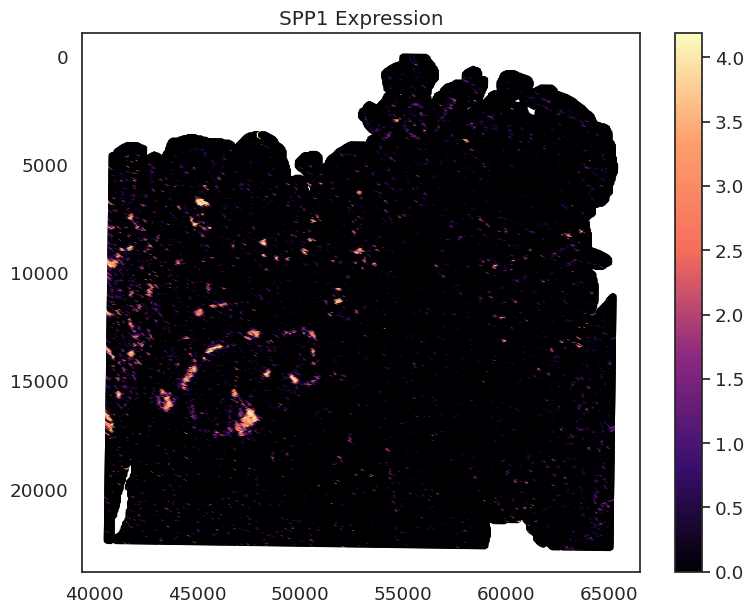

In [21]:
## visualisation
fstplt.gene_expr(adata, matrix_order_df, gene_selet='SPP1', save_path=None)

1.6 Save adata for the ground truth

In [22]:
## save original data
# patientxy = 'CRC16um'
# adata.write_h5ad(str(path)+'FineST/FineST_local/Dataset/'+str(patientxy)+'/'+str(patientxy)+'_adata_orignal.h5ad')

## 2 Train and Test model

2.1 Data loader and splitting: 80% for train and 20% for test

In [23]:
spatial_pos_path=str(path)+'FineST/FineST_local/Dataset/CRC16um/ContrastCRC16geneLR/position_order.csv'
reduced_mtx_path=str(path)+'FineST/FineST_local/Dataset/CRC16um/ContrastCRC16geneLR/harmony_matrix.npy'  
image_embed_path_CRC16=str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/HD_CRC_16um_pth_32_16/*.pth'

In [24]:
## split training data and test data 
train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
                                              image_embed_path=image_embed_path_CRC16, 
                                              spatial_pos_path=spatial_pos_path, 
                                              reduced_mtx_path=reduced_mtx_path, 
                                              dataset_class='VisiumHD')

***** Building loaders *****
Finished loading all files
train/test split completed
109563 27391
***** Finished building loaders *****


In [25]:
all_dataset = fst.build_loaders_inference(batch_size = adata.shape[0], 
                                          image_embed_path=image_embed_path_CRC16, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path, dataset_class='VisiumHD')

***** Building loaders_inference *****
Finished loading all files
***** Finished building loaders_inference *****


In [26]:
# input_spot_all, input_image_all, input_coord_all, input_row_all, input_col_all = fst.extract_test_data(all_dataset)
# print("input_spot_all:", input_spot_all.shape)
# print("input_image_all:", input_image_all.shape)
# print(input_image_all)
# print(input_spot_all)

In [27]:
# input_spot_test, input_image_test, input_coord_test, input_row_test, input_col_test = fst.extract_test_data(test_loader)
# print("input_spot_test:", input_spot_test.shape)
# print("input_image_test:", input_image_test.shape)
# print(input_image_test)
# print(input_spot_test)

2.2 Train and test model on 80% Viisum HD data with 16um

In [28]:
## load parameter settings
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

## add params
params['n_input_matrix'] = len(gene_hv)
params['n_input_image'] = 384

## init the model
model = fst.CellContrastModel(n_input_matrix=params['n_input_matrix'],
                              n_input_image=params['n_input_image'],
                              n_encoder_hidden_matrix=params["n_encoder_hidden_matrix"],
                              n_encoder_hidden_image=params["n_encoder_hidden_image"],
                              n_encoder_latent=params["n_encoder_latent"],
                              n_projection_hidden=params["n_projection_hidden"],
                              n_projection_output=params["n_projection_output"],
                              n_encoder_layers=params["n_encoder_layers"]).to(device) 
l = fst.ContrastiveLoss(temperature=params['temperature'])
# print(model)

## Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=params['inital_learning_rate'], momentum=0.9, weight_decay=5e-4)

## Load the data
train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
                                              image_embed_path=image_embed_path_CRC16, 
                                              spatial_pos_path=spatial_pos_path, 
                                              reduced_mtx_path=reduced_mtx_path, 
                                              dataset_class='VisiumHD')


# Train the model for a fixed number of epoch
logger.info('Begin Training ...')

start_time = time.time()

best_loss = float('inf')
best_epoch = 0
for epoch in range(params['training_epoch']):
    logger.info('epoch [{}/{}]'.format(epoch + 1, epoch))
    print(f"Epoch: {epoch + 1}")
    
    ######################################################################################
    # Train the model 
    ######################################################################################
    model.train()
    
    start_time = time.time()
    train_loss = fst.train_model(params, model, train_loader, optimizer, epoch, l, 
                                 tree_type='KDTree', leaf_size=2, dataset_class='VisiumHD')    # LOSS
    print("--- %s seconds ---" % (time.time() - start_time))
    
    ######################################################################################
    # Evaluate the model 
    ######################################################################################
    model.eval()
    with torch.no_grad():
        test_loss = fst.test_model(params, model, test_loader, l, 
                                tree_type='KDTree', leaf_size=2, dataset_class='VisiumHD') 
    
    if best_loss > test_loss:
        best_loss = test_loss
        best_epoch = epoch

        fst.save_model(model, dir_name, params, optimizer, train_loss)
        # torch.save(model.state_dict(), "STFinetune/best.pt")    # BLEEP
        print("Saved Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))
        logger.info("Saved Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))

print("Done!, final loss: {}".format(best_loss))
print("Best epoch: {}".format(best_epoch))

print("--- %s seconds ---" % (time.time() - start_time))

logger.info("Done!, Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))

logger.info('Finished Training')

***** Building loaders *****
Finished loading all files
train/test split completed
109563 27391
***** Finished building loaders *****


[2024-11-16 21:39:17] INFO - Begin Training ...
[2024-11-16 21:39:17] INFO - epoch [1/0]


Epoch: 1
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 62.10it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 201.24939608573914 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 51.43it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 21:42:44] INFO - Saved Best epoch & Best Model! Loss: [0: 8.975163908565746]
[2024-11-16 21:42:44] INFO - epoch [2/1]


Saved Best epoch & Best Model! Loss: [0: 8.975163908565746]
Epoch: 2
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.06it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 204.4416766166687 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 67.22it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 21:46:13] INFO - Saved Best epoch & Best Model! Loss: [1: 8.722227567784927]
[2024-11-16 21:46:13] INFO - epoch [3/2]


Saved Best epoch & Best Model! Loss: [1: 8.722227567784927]
Epoch: 3
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 78.99it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 232.80510067939758 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 80.23it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 21:50:10] INFO - Saved Best epoch & Best Model! Loss: [2: 8.699083182390998]
[2024-11-16 21:50:10] INFO - epoch [4/3]


Saved Best epoch & Best Model! Loss: [2: 8.699083182390998]
Epoch: 4
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.01it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 238.73175740242004 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.68it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 21:57:59] INFO - Saved Best epoch & Best Model! Loss: [4: 8.685985800799202]
[2024-11-16 21:57:59] INFO - epoch [6/5]


Saved Best epoch & Best Model! Loss: [4: 8.685985800799202]
Epoch: 6
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 66.89it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 238.92594981193542 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.31it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:02:03] INFO - Saved Best epoch & Best Model! Loss: [5: 8.669893960391773]
[2024-11-16 22:02:03] INFO - epoch [7/6]


Saved Best epoch & Best Model! Loss: [5: 8.669893960391773]
Epoch: 7
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 78.32it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 236.25941681861877 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.86it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:06:04] INFO - Saved Best epoch & Best Model! Loss: [6: 8.657483661876006]
[2024-11-16 22:06:04] INFO - epoch [8/7]


Saved Best epoch & Best Model! Loss: [6: 8.657483661876006]
Epoch: 8
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 74.33it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 238.21339416503906 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.97it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:10:07] INFO - Saved Best epoch & Best Model! Loss: [7: 8.626796756071203]
[2024-11-16 22:10:07] INFO - epoch [9/8]


Saved Best epoch & Best Model! Loss: [7: 8.626796756071203]
Epoch: 9
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.63it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 195.819082736969 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 63.95it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:13:27] INFO - Saved Best epoch & Best Model! Loss: [8: 8.592842539618998]
[2024-11-16 22:13:27] INFO - epoch [10/9]


Saved Best epoch & Best Model! Loss: [8: 8.592842539618998]
Epoch: 10
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.87it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 233.7632429599762 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 62.50it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:17:26] INFO - Saved Best epoch & Best Model! Loss: [9: 8.570259554245892]
[2024-11-16 22:17:26] INFO - epoch [11/10]


Saved Best epoch & Best Model! Loss: [9: 8.570259554245892]
Epoch: 11
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 74.56it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 236.64159536361694 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 80.25it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:21:27] INFO - Saved Best epoch & Best Model! Loss: [10: 8.561467013639563]
[2024-11-16 22:21:27] INFO - epoch [12/11]


Saved Best epoch & Best Model! Loss: [10: 8.561467013639563]
Epoch: 12
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.45it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 239.45896005630493 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 49.89it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:25:31] INFO - Saved Best epoch & Best Model! Loss: [11: 8.548956904691808]
[2024-11-16 22:25:31] INFO - epoch [13/12]


Saved Best epoch & Best Model! Loss: [11: 8.548956904691808]
Epoch: 13
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.27it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 224.1344871520996 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.29it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:29:20] INFO - Saved Best epoch & Best Model! Loss: [12: 8.54032449161305]
[2024-11-16 22:29:20] INFO - epoch [14/13]


Saved Best epoch & Best Model! Loss: [12: 8.54032449161305]
Epoch: 14
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:10<00:00, 53.73it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 225.25946593284607 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 59.27it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:33:11] INFO - Saved Best epoch & Best Model! Loss: [13: 8.528138216804056]
[2024-11-16 22:33:11] INFO - epoch [15/14]


Saved Best epoch & Best Model! Loss: [13: 8.528138216804056]
Epoch: 15
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.32it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 259.09072756767273 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 58.93it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:37:35] INFO - Saved Best epoch & Best Model! Loss: [14: 8.524636201297536]
[2024-11-16 22:37:35] INFO - epoch [16/15]


Saved Best epoch & Best Model! Loss: [14: 8.524636201297536]
Epoch: 16
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 68.05it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 261.51872992515564 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 45.49it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:42:02] INFO - Saved Best epoch & Best Model! Loss: [15: 8.518174788531136]
[2024-11-16 22:42:02] INFO - epoch [17/16]


Saved Best epoch & Best Model! Loss: [15: 8.518174788531136]
Epoch: 17
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.22it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 209.73852944374084 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.49it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:45:37] INFO - Saved Best epoch & Best Model! Loss: [16: 8.511366574904498]
[2024-11-16 22:45:37] INFO - epoch [18/17]


Saved Best epoch & Best Model! Loss: [16: 8.511366574904498]
Epoch: 18
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 71.57it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 220.06509256362915 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 79.96it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:49:21] INFO - epoch [19/18]


Epoch: 19
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 69.21it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 260.5784766674042 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 62.69it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:53:47] INFO - Saved Best epoch & Best Model! Loss: [18: 8.506684819389791]
[2024-11-16 22:53:47] INFO - epoch [20/19]


Saved Best epoch & Best Model! Loss: [18: 8.506684819389791]
Epoch: 20
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 77.94it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 256.57958936691284 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 71.03it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 22:58:07] INFO - epoch [21/20]


Epoch: 21
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 80.27it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 220.00345277786255 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 71.14it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:01:52] INFO - epoch [22/21]


Epoch: 22
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 70.29it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 223.72665929794312 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 66.18it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:05:40] INFO - epoch [23/22]


Epoch: 23
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 78.92it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 220.09693217277527 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 65.70it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:09:25] INFO - epoch [24/23]


Epoch: 24
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 78.59it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 183.85900235176086 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 62.02it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:12:34] INFO - epoch [25/24]


Epoch: 25
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.89it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 223.48466682434082 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 74.92it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:16:22] INFO - Saved Best epoch & Best Model! Loss: [24: 8.504134615729837]
[2024-11-16 23:16:22] INFO - epoch [26/25]


Saved Best epoch & Best Model! Loss: [24: 8.504134615729837]
Epoch: 26
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:10<00:00, 52.36it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 225.0206458568573 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 74.64it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:20:11] INFO - epoch [27/26]


Epoch: 27
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 80.02it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 213.93636012077332 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.49it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:23:50] INFO - epoch [28/27]


Epoch: 28
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 73.58it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 257.92259335517883 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 75.37it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:28:12] INFO - epoch [29/28]


Epoch: 29
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 80.31it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 221.33996629714966 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.71it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:31:59] INFO - epoch [30/29]


Epoch: 30
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 80.20it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 222.05522799491882 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 73.03it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:35:45] INFO - epoch [31/30]


Epoch: 31
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 78.65it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 199.09636187553406 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 72.23it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:39:08] INFO - epoch [32/31]


Epoch: 32
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 80.04it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 186.27576446533203 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.03it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:42:20] INFO - epoch [33/32]


Epoch: 33
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.27it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 187.55485081672668 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.60it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:45:32] INFO - epoch [34/33]


Epoch: 34
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.09it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 199.21477723121643 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 71.63it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:48:56] INFO - epoch [35/34]


Epoch: 35
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 75.17it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 223.1286654472351 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 61.22it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:52:44] INFO - epoch [36/35]


Epoch: 36
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 80.77it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 223.6116373538971 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 79.08it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-16 23:56:32] INFO - epoch [37/36]


Epoch: 37
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 77.98it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 262.46787118911743 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 63.56it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:00:59] INFO - epoch [38/37]


Epoch: 38
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.41it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 208.40636563301086 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 37.16it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:04:34] INFO - epoch [39/38]


Epoch: 39
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.80it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 223.4206578731537 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 79.87it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:08:22] INFO - epoch [40/39]


Epoch: 40
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 80.16it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 225.28092527389526 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 81.72it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:12:11] INFO - epoch [41/40]


Epoch: 41
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.99it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 216.80885672569275 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 62.04it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:15:53] INFO - epoch [42/41]


Epoch: 42
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.52it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 214.01655459403992 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 64.36it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:19:31] INFO - epoch [43/42]


Epoch: 43
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.52it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 220.54478478431702 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 62.34it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:23:17] INFO - epoch [44/43]


Epoch: 44
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.85it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 226.3998749256134 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 73.89it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:27:08] INFO - epoch [45/44]


Epoch: 45
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 73.08it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 229.8883867263794 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 59.62it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:31:03] INFO - epoch [46/45]


Epoch: 46
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 77.25it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 208.48061537742615 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 73.42it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:34:35] INFO - epoch [47/46]


Epoch: 47
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:06<00:00, 79.51it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 264.2293257713318 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 71.31it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:39:04] INFO - epoch [48/47]


Epoch: 48
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 72.56it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 231.53113532066345 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 68.32it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:42:59] INFO - epoch [49/48]


Epoch: 49
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 72.50it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 230.4801664352417 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 63.00it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:46:55] INFO - epoch [50/49]


Epoch: 50
train model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:07<00:00, 69.53it/s]


image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 225.84434819221497 seconds ---
test model


100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 35.66it/s]


image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............


[2024-11-17 00:50:47] INFO - Done!, Best epoch & Best Model! Loss: [24: 8.504134615729837]
[2024-11-17 00:50:47] INFO - Finished Training


Done!, final loss: 8.504134615729837
Best epoch: 24
--- 232.26375079154968 seconds ---


In [29]:
!pwd

/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/CRC16um/spatial


***** Building loaders *****
Finished loading all files
train/test split completed
109563 27391
***** Finished building loaders *****
[2024-11-16 21:39:17] INFO - Begin Training ...
[2024-11-16 21:39:17] INFO - epoch [1/0]
Epoch: 1
train model
100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 62.10it/s]
image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 201.24939608573914 seconds ---
test model
100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 51.43it/s]
image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............
[2024-11-16 21:42:44] INFO - Saved Best epoch & Best Model! Loss: [0: 8.975163908565746]
[2024-11-16 21:42:44] INFO - epoch [2/1]
Saved Best epoch & Best Model! Loss: [0: 8.975163908565746]
Epoch: 2
train model
100%|█████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:08<00:00, 61.06it/s]
image_tensor: torch.Size([109400, 4, 384])
checkNeighbors.............
--- 204.4416766166687 seconds ---
test model
100%|█████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 67.22it/s]
image_tensor: torch.Size([27200, 4, 384])
checkNeighbors.............
[2024-11-16 21:46:13] INFO - Saved Best epoch & Best Model! Loss: [1: 8.722227567784927]
[2024-11-16 21:46:13] INFO - epoch [3/2]
Saved Best epoch & Best Model! Loss: [1: 8.722227567784927]Best Model! Loss: [1: 8.700643864799948]

## 3. Inference sub-bins using trained model, Imputation using measured bin data, and Evaluation bin or sub-bin level prediction

3.1 Inference: within spot

In [30]:
dir_name

'/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20241116211723850793'

In [31]:
# dir_name = '/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20241108154030954276'   
dir_name = '/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20241116211723850793'  

In [32]:
# load params
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

# load models
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)  
model.to(device)
# print("model", model)

## load all data
test_loader = fst.build_loaders_inference(batch_size=adata.shape[0], 
                                          image_embed_path=image_embed_path_CRC16, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path,
                                          dataset_class='VisiumHD')

## inference
logger.info("Running inference tesk...")

start_time = time.time()

(matrix_profile, 
reconstructed_matrix, 
recon_ref_adata_image_f2, 
representation_image_reshape,
representation_matrix,
projection_image_reshape,
projection_matrix,
input_image_exp,
reconstruction_iamge,
reconstructed_matrix_reshaped,
input_coord_all) = fst.perform_inference_image(model, test_loader, dataset_class='VisiumHD')

print("--- %s seconds ---" % (time.time() - start_time))
print("print(reconstructed_matrix_reshaped.shape)", reconstructed_matrix_reshaped.shape)

logger.info("Running inference tesk DONE!")

***** Building loaders_inference *****


[2024-11-17 15:25:20] INFO - Running inference tesk...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.52s/it]


***** batch_size=adata.shape[0] doen't effect *****
torch.Size([136954, 862])
torch.Size([136954, 4, 384])
1
1
1
***** *****
Finished extractting test data


[2024-11-17 15:25:34] INFO - Running inference tesk DONE!


--- 13.990924835205078 seconds ---
print(reconstructed_matrix_reshaped.shape) torch.Size([547816, 862])


3.2 Get coordinates of sub-bins (8 um bins) from 16 um bins

In [33]:
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped,
                                                                   dataset_class='VisiumHD')
print(reconstructed_matrix_reshaped_tensor.shape)

torch.Size([136954, 4, 862])


first_spot_first_variable shape: (4,)


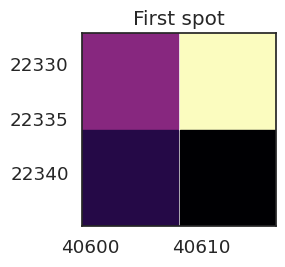

In [34]:
## plot the sub-spot level gene expression of the first gene in the first within spot
(first_spot_first_variable, C,
 _, _, _) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                         adata, gene_hv, p=0, q=0, dataset_class="VisiumHD")
print("first_spot_first_variable shape:", first_spot_first_variable.shape)
fst.subspot_expr(C, first_spot_first_variable, marker='s', s=15800, save_path=None)

In [35]:
## Get the sub-spot level gene expression of all genes in all within spots
(_, _, all_spot_all_variable,
 C2, adata_spot) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                adata, gene_hv, dataset_class="VisiumHD")
print("all_spot_all_variable shape:", all_spot_all_variable.shape)
print(adata_spot)

all_spot_all_variable shape: (547816, 862)
AnnData object with n_obs × n_vars = 547816 × 862
    obs: 'x', 'y'


3.3 Impute the gene expression of sub-bins

In [36]:
sudo_adata, adata_impt, data_impt = fst.impute_adata(adata, adata_spot, C2, gene_hv, k=6, w=0.5)
print(sudo_adata)
print(adata_impt)

--- 1501.883879184723 seconds ---
AnnData object with n_obs × n_vars = 547816 × 862
    obs: 'x', 'y'
AnnData object with n_obs × n_vars = 547816 × 862
    obs: 'x', 'y'


In [37]:
_, data_impt_reshape = fst.reshape_latent_image(data_impt, dataset_class='VisiumHD')
print("data_impt shape:", data_impt.shape)
print("data_impt_reshape shape:", data_impt_reshape.shape)

data_impt shape: torch.Size([547816, 862])
data_impt_reshape shape: torch.Size([136954, 862])


In [38]:
############################################
## using the weight and add
## adata_spot: inferred results
## sudo_adata: imputed results
############################################
print(adata.X.A)
print(adata_spot.X)
print(sudo_adata.X)

[[0.        0.        1.3418427 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
[[0.05178811 0.21185137 0.43554312 ... 0.05611318 0.04595444 0.01557337]
 [0.05462322 0.20479658 0.45661092 ... 0.05618425 0.04552122 0.01574916]
 [0.05056844 0.2112345  0.42587644 ... 0.05530891 0.04564461 0.01543362]
 ...
 [0.05112964 0.2105497  0.47000074 ... 0.05093745 0.04381944 0.01553464]
 [0.05114654 0.21072754 0.47021049 ... 0.05099344 0.04381669 0.01553703]
 [0.0511097  0.21041518 0.46979749 ... 0.05097201 0.04376268 0.01552001]]
[[0.         0.         0.38814867 ... 0.         0.3649052  0.        ]
 [0.         0.         0.42594724 ... 0.         0.362776   0.        ]
 [

3.4 Visualization: selected gene (Visium HD vs. FineST)

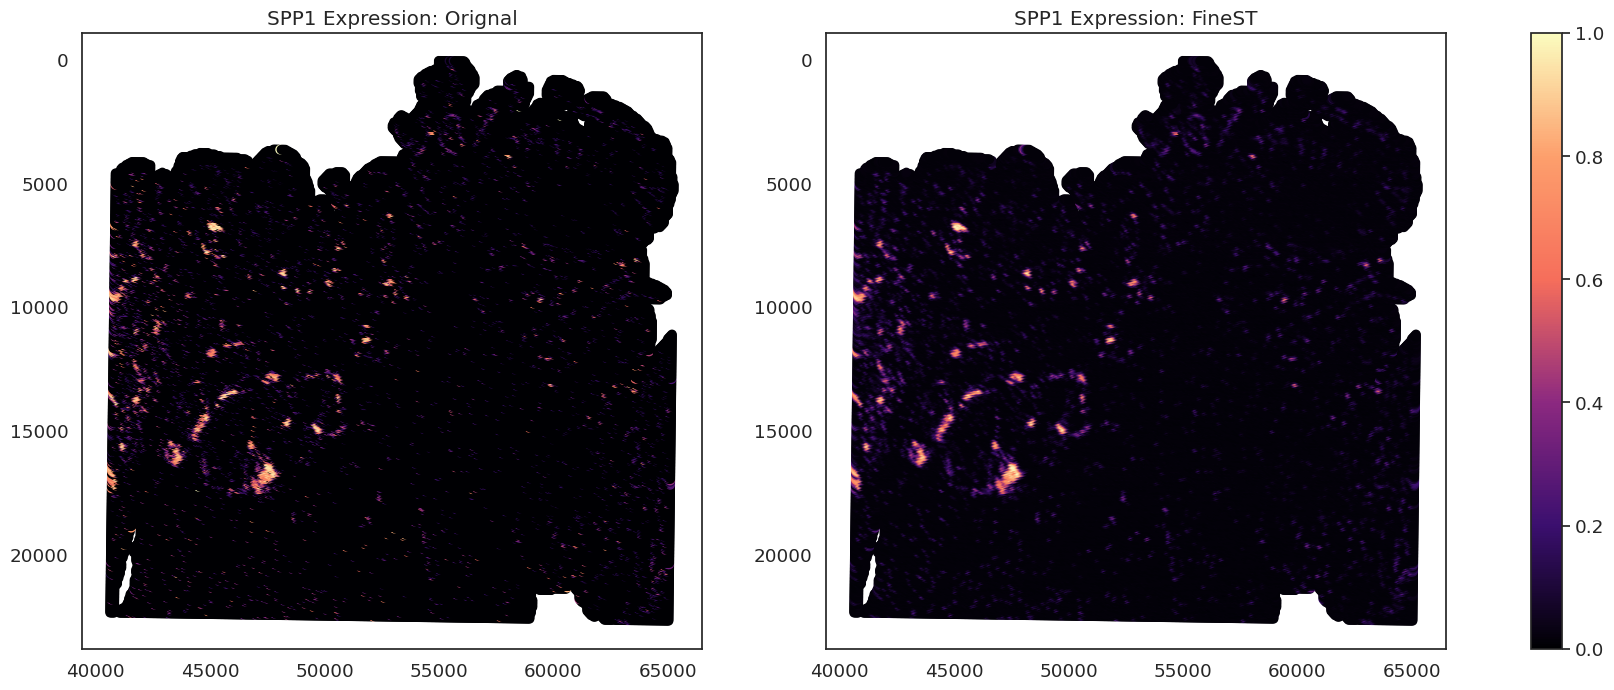

In [39]:
fstplt.gene_expr_compare(adata, "SPP1", data_impt_reshape, gene_hv, save_path=None)

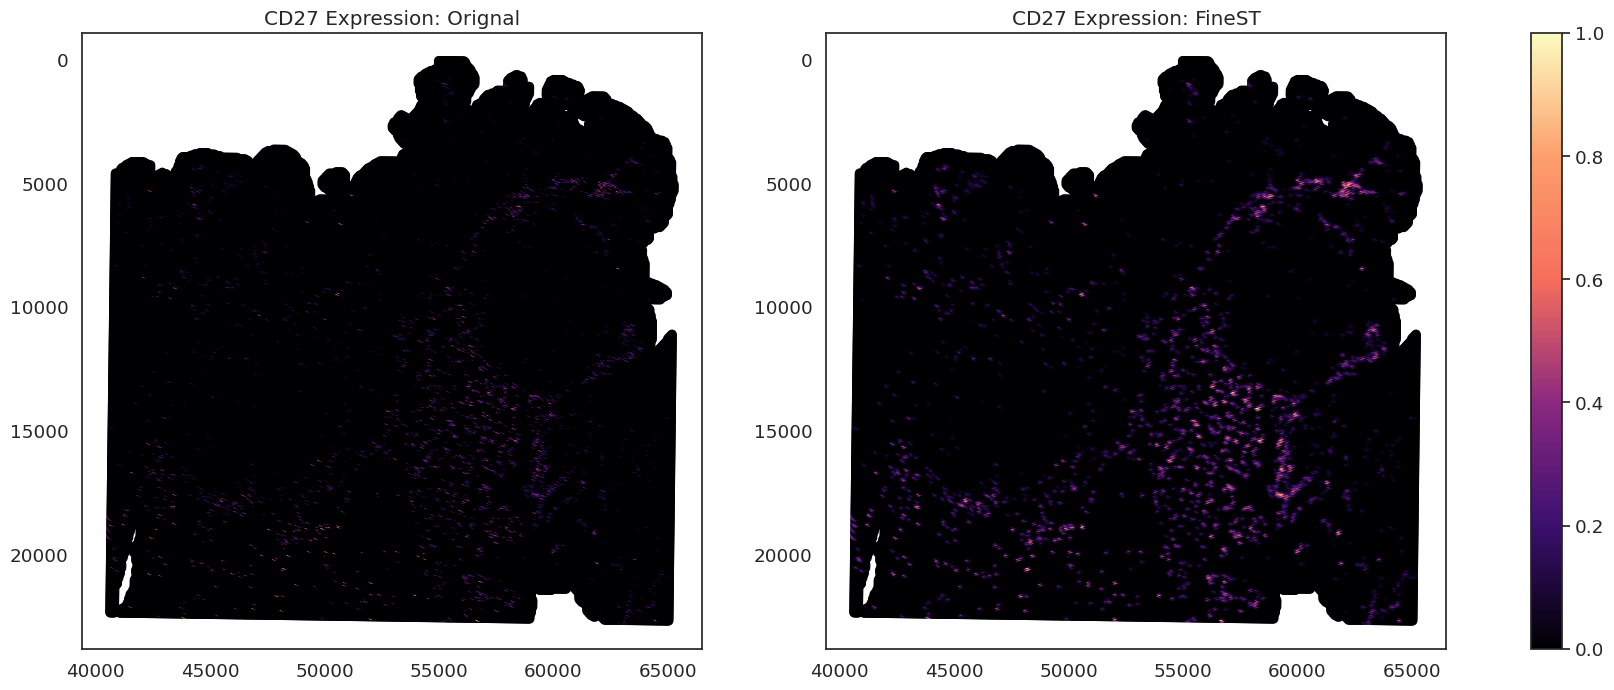

In [40]:
fstplt.gene_expr_compare(adata, "CD27", data_impt_reshape, gene_hv, save_path=None)

3.4 Correlation on 16um: Selected gene、all spots and all genes、mean correlation box

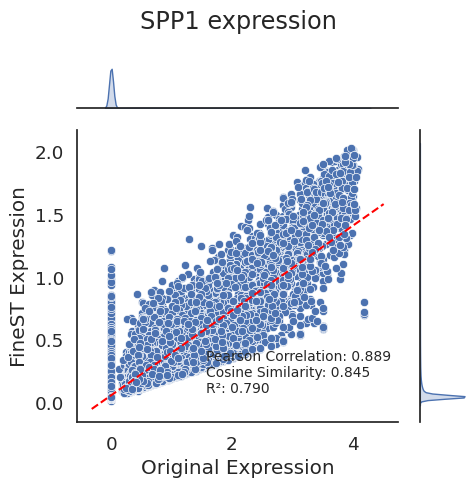

In [41]:
## if ones wants to save the figure in .pdf format, just set: save_path=str(gene)+'correlation.pdf'
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "SPP1",
                     ylabel='FineST Expression', title = "SPP1 expression", size=5,
                     save_path=None)

In [42]:
logger.info("Running correlation task...")

(pearson_cor_spot,
 spearman_cor_spot,
 cosine_sim_spot) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="spot")

logger.info("Running correlation task DINE!")

[2024-11-17 16:29:34] INFO - Running correlation task...


matrix1:  (136954, 862)
matrix2:  (136954, 862)
Mean Pearson correlation coefficient--reconf2: 0.7312
Mean Spearman correlation coefficient--reconf2: 0.3236


[2024-11-17 16:31:23] INFO - Running correlation task DINE!


Mean cosine similarity--reconf2: 0.5972


In [43]:
logger.info("Running Gene Correlation task...")

(pearson_cor_gene,
 spearman_cor_gene,
 cosine_sim_gene) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="gene")

logger.info("Running Gene Correlation task DINE!")

[2024-11-17 16:31:23] INFO - Running Gene Correlation task...


matrix1:  (136954, 862)
matrix2:  (136954, 862)
Mean Pearson correlation coefficient--reconf2: 0.7491
Mean Spearman correlation coefficient--reconf2: 0.2331


[2024-11-17 16:31:55] INFO - Running Gene Correlation task DINE!


Mean cosine similarity--reconf2: 0.5972


0.7233473197463364
0.7491409608052803


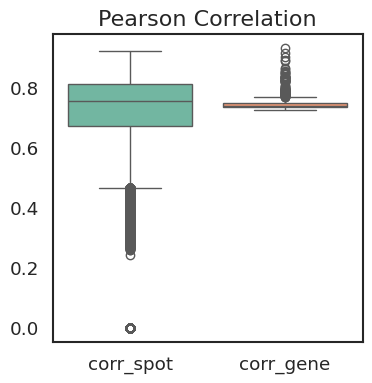

In [44]:
fstplt.mean_cor_box(adata, data_impt_reshape, save_path=None)

3.5 Correlation on 8um: Selected gene、all spots and all genes、mean correlation box

In [45]:
## Load 8um original data from VisiumHD 
adata_8um = sc.read_h5ad(str(path)+'VisiumHD/Dataset/Colon_Cancer_square_008um.h5ad')
adata_8um = adata_8um[:, adata.var_names]
print(adata_8um)

View of AnnData object with n_obs × n_vars = 545913 × 862
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [46]:
## Data preprocess
adata_8um = fst.adata_preprocess(adata_8um)
print(adata_8um)

AnnData object with n_obs × n_vars = 545913 × 862
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


In [47]:
## The predicted 8um data from FineST
adata_impt.obsm['spatial'] = np.stack([adata_impt.obs['x'], adata_impt.obs['y']], -1)
adata_impt.uns['spatial'] = adata_8um.uns['spatial']
print(adata_impt)

AnnData object with n_obs × n_vars = 547816 × 862
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [49]:
adata_impt_align, _, _ = fst.align_adata_fst2hd(adata_impt, adata_8um)
print(adata_impt_align)

AnnData object with n_obs × n_vars = 545913 × 862
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


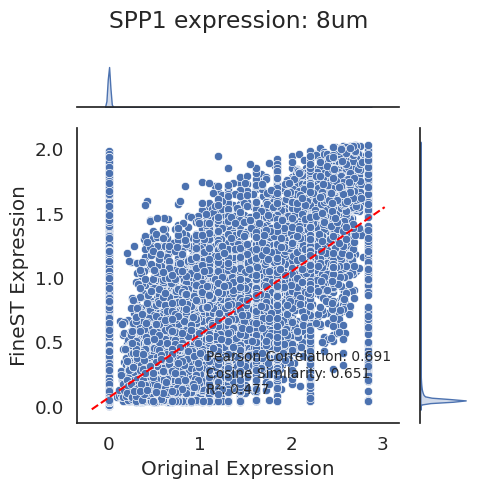

In [50]:
## Noemalized
fstplt.sele_gene_cor(adata_8um, adata_impt_align.to_df(), gene_hv, gene = "SPP1",
                     ylabel='FineST Expression', title = "SPP1 expression: 8um", size=5,
                     save_path=None)

In [51]:
## Noemalized
logger.info("Running Gene Correlation task...")

(pearson_cor_gene,
 spearman_cor_gene,
 cosine_sim_gene) = fst.mean_cor(adata_8um, adata_impt_align.to_df(), 'reconf2', sample="gene")

logger.info("Running Gene Correlation task DINE!")

[2024-11-17 16:33:43] INFO - Running Gene Correlation task...


matrix1:  (545913, 862)
matrix2:  (545913, 862)
Mean Pearson correlation coefficient--reconf2: 0.2892
Mean Spearman correlation coefficient--reconf2: 0.1077


[2024-11-17 16:36:21] INFO - Running Gene Correlation task DINE!


Mean cosine similarity--reconf2: 0.2496


0.28918661261574635


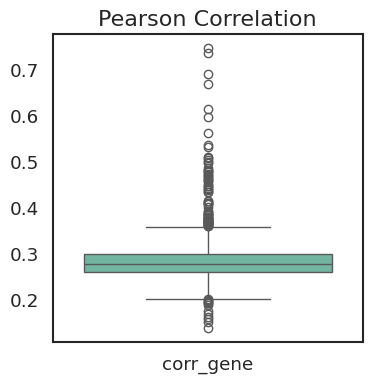

In [53]:
## Noemalized
fst.mean_cor_box(adata_8um, np.array(adata_impt_align.to_df()), gene_only=True, save_path=None)

3.6 Convert 8um gene expression to 16um and save these two size adata

In [54]:
## save adata: 8um
# patientxy = 'CRC16um'
# adata_impt.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_pre08um.h5ad')

In [55]:
## process_and_check_duplicates 0f the coordinates of all spots (within and between)
spatial_loc_all = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_all)

Are there any duplicate rows? : False
[[40624.276539 22352.723279]
 [40682.662627 22353.50739 ]
 [40741.048834 22354.291503]
 ...
 [55986.186249    67.933635]
 [56044.567187    68.694824]
 [56102.948244    69.456014]]


In [56]:
adata_impt_pre16um = sc.AnnData(X = pd.DataFrame(data_impt_reshape.cpu().detach().numpy()))
adata_impt_pre16um.var_names = adata.var_names
adata_impt_pre16um.obs_names = adata.obs_names
adata_impt_pre16um.obs = adata.obs
adata_impt_pre16um.obs['x'] = spatial_loc_all[:,0]
adata_impt_pre16um.obs['y'] = spatial_loc_all[:,1]
print("adata_impt_pre16um: ", adata_impt_pre16um)

adata_impt_pre16um:  AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col', 'x', 'y'


In [57]:
## save adata: 16um
# patientxy = 'CRC16um'
# adata_impt_pre16um.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_pre16um.h5ad')

3.7 Visualization: gene at all bin and sub-bin

SPP1 gene expression dim:  (136954, 1)
SPP1 gene expression: 
 [[0.04261655]
 [0.04224425]
 [0.04304874]
 ...
 [0.04568546]
 [0.04575672]
 [0.04571219]]


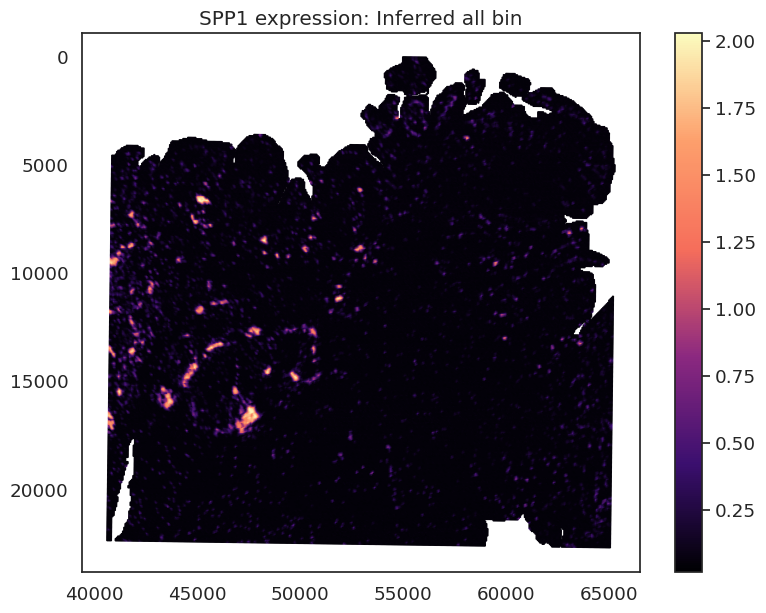

In [58]:
fstplt.gene_expr_allspots("SPP1", spatial_loc_all, data_impt_reshape, gene_hv, 
                          'Inferred all bin', s=0.5, save_path=None)

SPP1 gene expression dim:  (547816, 1)
SPP1 gene expression: 
 [[0.044882  ]
 [0.04120104]
 [0.03982099]
 ...
 [0.04582335]
 [0.04575482]
 [0.04563507]]


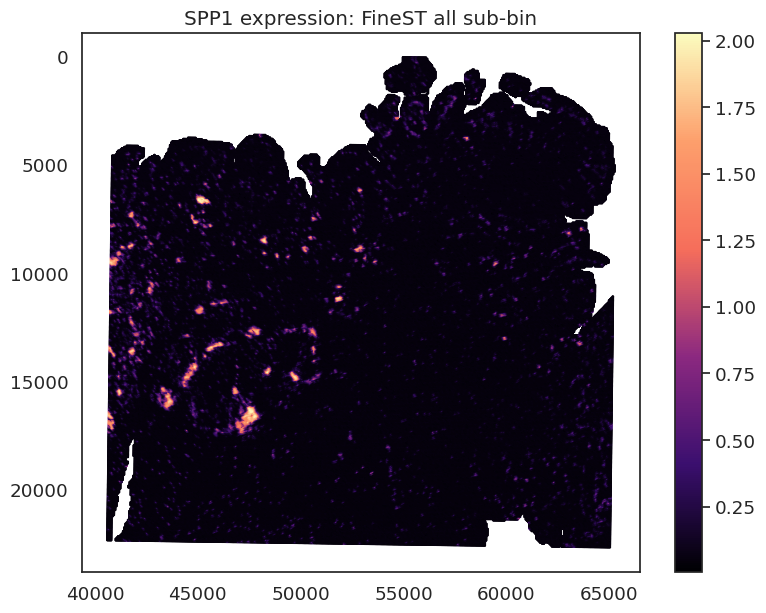

In [59]:
fstplt.gene_expr_allspots("SPP1", C2, adata_impt.X, gene_hv,
                          'FineST all sub-bin', s=0.5, save_path=None)

## 4. Load predicted adata (bin-level) for ligand-receptor interaction discovery

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
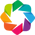

1.7.1
SpatailDM version: 0.2.0
FineST version: 0.0.5


In [60]:
import os
import time
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

import spatialdm as sdm
from spatialdm.datasets import dataset
import spatialdm.plottings as pl
import matplotlib.pyplot as plt

import FineST as fst
from FineST.datasets import dataset
import FineST.plottings as fstplt

print(torch.__version__)
print("SpatailDM version: %s" %sdm.__version__)
print("FineST version: %s" %fst.__version__)

In [61]:
path = '/mnt/lingyu/nfs_share2/Python/'
patientxy = 'CRC16um'
adata_impt_all = sc.read_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_pre16um.h5ad')
adata_impt_all.obsm['spatial'] = np.column_stack((adata_impt_all.obs['x'].values,
                                                  adata_impt_all.obs['y'].values))
print(adata_impt_all)           

AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col', 'x', 'y'
    obsm: 'spatial'


4.1 Get weight_matrix by rbf kernel

In [62]:
######################
# different 
######################
import json
from pathlib import Path
path_to_visium_bundle = Path(str(path)+"FineST/FineST_local/Dataset/CRC16um").expanduser()
with open(path_to_visium_bundle / "spatial" / "scalefactors_json.json") as file:
    visium_scale_factors = json.load(file)

print(visium_scale_factors)
print(visium_scale_factors["spot_diameter_fullres"])

{'spot_diameter_fullres': 58.417196833905315, 'bin_size_um': 16.0, 'microns_per_pixel': 0.27389195078106876, 'regist_target_img_scalef': 0.07973422, 'tissue_lowres_scalef': 0.007973422, 'fiducial_diameter_fullres': 1204.854684699297, 'tissue_hires_scalef': 0.07973422}
58.417196833905315


In [63]:
####################################################################
# Differenr
####################################################################
# spot_diameter_fullres = 130    # reference SVZ datset in SpatialDM
spot_diameter_fullres=visium_scale_factors["spot_diameter_fullres"]

# fst.weight_matrix(adata_impt_all, l = spot_diameter_fullres,
#               cutoff = 0.001, single_cell = False, n_nearest_neighbors=6)

#####################################################################
# different: single_cell = True
# single cell resolution, diagonal will be made 0
#####################################################################
fst.weight_matrix(adata_impt_all, l = spot_diameter_fullres,
              cutoff = 0.001, single_cell = True, n_nearest_neighbors=6)

print(adata_impt_all)

AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col', 'x', 'y'
    uns: 'single_cell'
    obsm: 'spatial'
    obsp: 'weight', 'nearest_neighbors'


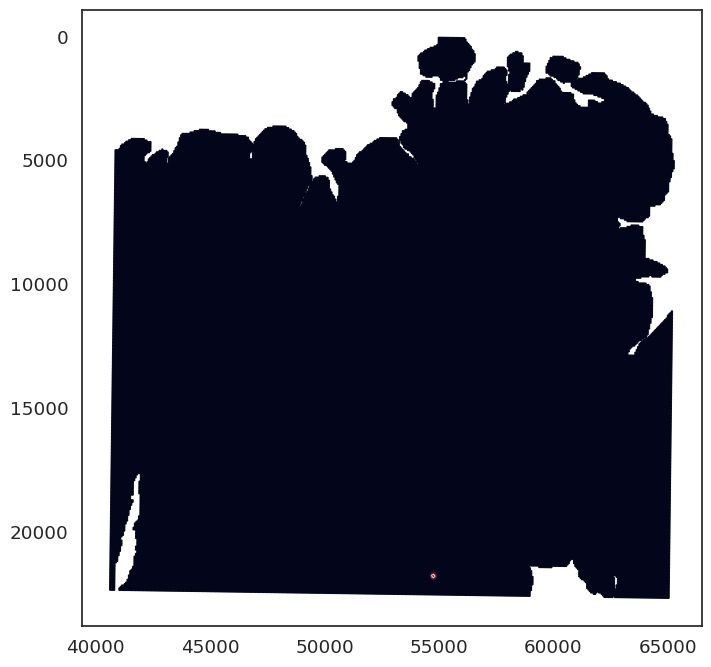

In [64]:
## Visualize the range of interaction
plt.figure(figsize=(8, 8))
plt.scatter(adata_impt_all.obsm['spatial'][:,0], adata_impt_all.obsm['spatial'][:,1],
            c=adata_impt_all.obsp['weight'].A[5000], s=0.5)
plt.gca().invert_yaxis()

4.2 Extract valid LR pairs from the database

In [65]:
## find overlapping LRs from CellChatDB
start = time.time()
sdm.extract_lr(adata_impt_all, 'human', min_cell=3)
print("%.3f seconds" %(time.time()-start))
print(adata_impt_all)

65.383 seconds
AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col', 'x', 'y'
    uns: 'single_cell', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'
    obsm: 'spatial'
    obsp: 'weight', 'nearest_neighbors'


In [66]:
adata_impt_all.uns['geneInter']

interaction_name  pathway_name agonist antagonist co_A_receptor  \
VSIR_IGSF11      VSIR_IGSF11         VISTA     NaN        NaN           NaN   
EFNA5_EPHA7      EFNA5_EPHA7          EPHA     NaN        NaN           NaN   
EFNA5_EPHA8      EFNA5_EPHA8          EPHA     NaN        NaN           NaN   
EFNA5_EPHB2      EFNA5_EPHB2          EPHA     NaN        NaN           NaN   
EFNB1_EPHA4      EFNB1_EPHA4          EPHB     NaN        NaN           NaN   
...                      ...           ...     ...        ...           ...   
CCL22_CCR4        CCL22_CCR4           CCL     NaN        NaN           NaN   
CCL17_CCR4        CCL17_CCR4           CCL     NaN        NaN           NaN   
CCL27_CCR3        CCL27_CCR3           CCL     NaN        NaN           NaN   
CXCL1_ACKR1      CXCL1_ACKR1          CXCL     NaN        NaN           NaN   
CORT_SSTR2        CORT_SSTR2  SEMATOSTATIN     NaN        NaN           NaN   

            co_I_receptor                       evidence          annotation  \
VSIR_IGSF11           NaN                 KEGG: hsa04514   Cell-Cell Contact   
EFNA5_EPHA7           NaN                 PMID: 15114347   Cell-Cell Contact   
EFNA5_EPHA8           NaN                 PMID: 15114347   Cell-Cell Contact   
EFNA5_EPHB2           NaN  PMID:15107857; PMID: 15114347   Cell-Cell Contact   
EFNB1_EPHA4           NaN                 PMID: 15114347   Cell-Cell Contact   
...                   ...                            ...                 ...   
CCL22_CCR4            NaN                 KEGG: hsa04060  Secreted Signaling   
CCL17_CCR4            NaN                 KEGG: hsa04060  Secreted Signaling   
CCL27_CCR3            NaN                 KEGG: hsa04060  Secreted Signaling   
CXCL1_ACKR1           NaN                 PMID: 26740381  Secreted Signaling   
CORT_SSTR2            NaN                 KEGG: hsa04080  Secreted Signaling   

            interaction_name_2  
VSIR_IGSF11      VSIR - IGSF11  
EFNA5_EPHA7      EFNA5 - EPHA7  
EFNA5_EPHA8      EFNA5 - EPHA8  
EFNA5_EPHB2      EFNA5 - EPHB2  
EFNB1_EPHA4      EFNB1 - EPHA4  
...                        ...  
CCL22_CCR4        CCL22 - CCR4  
CCL17_CCR4        CCL17 - CCR4  
CCL27_CCR3        CCL27 - CCR3  
CXCL1_ACKR1      CXCL1 - ACKR1  
CORT_SSTR2        CORT - SSTR2  

[1791 rows x 9 columns]

4.3 Global selection (z-score approach)

In [67]:
## Identify dataset-specific interacting LR pairs (global selection)
start = time.time()

# global Moran selection
sdm.spatialdm_global(adata_impt_all, n_perm=1000, specified_ind=None, method='z-score', nproc=1)

# select significant pairs
sdm.sig_pairs(adata_impt_all, method='z-score', fdr=True, threshold=0.1)

print("%.3f seconds" %(time.time()-start))
print(adata_impt_all)

39.505 seconds
AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col', 'x', 'y'
    uns: 'single_cell', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter', 'global_I', 'global_stat', 'global_res'
    obsm: 'spatial'
    obsp: 'weight', 'nearest_neighbors'


In [68]:
spa_coexp_pair = adata_impt_all.uns['global_res']
spa_coexp_pair

Ligand0 Ligand1 Receptor0 Receptor1 Receptor2        z_pval  \
VSIR_IGSF11    VSIR    None    IGSF11      None      None  7.380340e-01   
EFNA5_EPHA7   EFNA5    None     EPHA7      None      None  2.099299e-74   
EFNA5_EPHA8   EFNA5    None     EPHA8      None      None  8.244257e-01   
EFNA5_EPHB2   EFNA5    None     EPHB2      None      None  1.000000e+00   
EFNB1_EPHA4   EFNB1    None     EPHA4      None      None  3.355164e-13   
...             ...     ...       ...       ...       ...           ...   
CCL22_CCR4    CCL22    None      CCR4      None      None  0.000000e+00   
CCL17_CCR4    CCL17    None      CCR4      None      None  0.000000e+00   
CCL27_CCR3    CCL27    None      CCR3      None      None  1.219105e-03   
CXCL1_ACKR1   CXCL1    None     ACKR1      None      None  1.000000e+00   
CORT_SSTR2     CORT    None     SSTR2      None      None  4.500856e-48   

                      z           fdr  selected  
VSIR_IGSF11   -0.637296  1.000000e+00     False  
EFNA5_EPHA7   18.211300  6.911480e-74      True  
EFNA5_EPHA8   -0.932364  1.000000e+00     False  
EFNA5_EPHB2  -30.776872  1.000000e+00     False  
EFNB1_EPHA4    7.185211  8.164535e-13      True  
...                 ...           ...       ...  
CCL22_CCR4   178.551153  0.000000e+00      True  
CCL17_CCR4   186.066719  0.000000e+00      True  
CCL27_CCR3     3.030906  2.456037e-03      True  
CXCL1_ACKR1 -103.734235  1.000000e+00     False  
CORT_SSTR2    14.520374  1.350257e-47      True  

[1791 rows x 9 columns]

In [73]:
## see the unique gene of sig LR pairs
LRgene_sc = fst.LRpair_gene(spa_coexp_pair)
print(LRgene_sc.shape)
print("spa_coexp_pairTgene shape: ", len(LRgene_sc))

(657, 1)
spa_coexp_pairTgene shape:  657


In [74]:
## use fdr corrected global p-values and a threshold FDR < 0.1 (default)
print(adata_impt_all.uns['global_res'].selected.sum())
adata_impt_all.uns['global_res'].sort_values(by='fdr')

971


Ligand0 Ligand1 Receptor0 Receptor1 Receptor2    z_pval  \
PTN_SDC2               PTN    None      SDC2      None      None  0.000000   
LAMA5_ITGA1_ITGB1    LAMA5    None     ITGA1     ITGB1      None  0.000000   
LAMA4_ITGA1_ITGB1    LAMA4    None     ITGA1     ITGB1      None  0.000000   
LAMA2_ITGA1_ITGB1    LAMA2    None     ITGA1     ITGB1      None  0.000000   
FN1_ITGA8_ITGB1        FN1    None     ITGA8     ITGB1      None  0.000000   
...                    ...     ...       ...       ...       ...       ...   
WNT4_FZD7_LRP5        WNT4    None      FZD7      LRP5      None  1.000000   
WNT4_FZD6_LRP5        WNT4    None      FZD6      LRP5      None  1.000000   
WNT4_FZD5_LRP5        WNT4    None      FZD5      LRP5      None  0.998787   
BMP6_BMPR1A_ACVR2B    BMP6    None    BMPR1A    ACVR2B      None  1.000000   
VSIR_IGSF11           VSIR    None    IGSF11      None      None  0.738034   

                             z  fdr  selected  
PTN_SDC2             58.083450  0.0      True  
LAMA5_ITGA1_ITGB1    97.050574  0.0      True  
LAMA4_ITGA1_ITGB1   229.493950  0.0      True  
LAMA2_ITGA1_ITGB1    41.821757  0.0      True  
FN1_ITGA8_ITGB1      85.780647  0.0      True  
...                        ...  ...       ...  
WNT4_FZD7_LRP5      -26.741460  1.0     False  
WNT4_FZD6_LRP5      -18.893537  1.0     False  
WNT4_FZD5_LRP5       -3.032453  1.0     False  
BMP6_BMPR1A_ACVR2B  -56.745259  1.0     False  
VSIR_IGSF11          -0.637296  1.0     False  

[1791 rows x 9 columns]

In [78]:
spa_coexp_pair = fst.anno_LRpair(adata_impt_all)
spa_coexp_pair

Ligand0 Ligand1 Receptor0 Receptor1 Receptor2    z_pval  \
PTN_SDC2               PTN    None      SDC2      None      None  0.000000   
LAMA5_ITGA1_ITGB1    LAMA5    None     ITGA1     ITGB1      None  0.000000   
LAMA4_ITGA1_ITGB1    LAMA4    None     ITGA1     ITGB1      None  0.000000   
LAMA2_ITGA1_ITGB1    LAMA2    None     ITGA1     ITGB1      None  0.000000   
FN1_ITGA8_ITGB1        FN1    None     ITGA8     ITGB1      None  0.000000   
...                    ...     ...       ...       ...       ...       ...   
WNT4_FZD7_LRP5        WNT4    None      FZD7      LRP5      None  1.000000   
WNT4_FZD6_LRP5        WNT4    None      FZD6      LRP5      None  1.000000   
WNT4_FZD5_LRP5        WNT4    None      FZD5      LRP5      None  0.998787   
BMP6_BMPR1A_ACVR2B    BMP6    None    BMPR1A    ACVR2B      None  1.000000   
VSIR_IGSF11           VSIR    None    IGSF11      None      None  0.738034   

                             z  fdr  selected                        evidence  \
PTN_SDC2             58.083450  0.0      True  PMID: 28356350; PMID: 25620911   
LAMA5_ITGA1_ITGB1    97.050574  0.0      True                  KEGG: hsa04512   
LAMA4_ITGA1_ITGB1   229.493950  0.0      True                  KEGG: hsa04512   
LAMA2_ITGA1_ITGB1    41.821757  0.0      True                  KEGG: hsa04512   
FN1_ITGA8_ITGB1      85.780647  0.0      True                  KEGG: hsa04512   
...                        ...  ...       ...                             ...   
WNT4_FZD7_LRP5      -26.741460  1.0     False  KEGG: hsa04310; PMID: 23209147   
WNT4_FZD6_LRP5      -18.893537  1.0     False  KEGG: hsa04310; PMID: 23209147   
WNT4_FZD5_LRP5       -3.032453  1.0     False  KEGG: hsa04310; PMID: 23209147   
BMP6_BMPR1A_ACVR2B  -56.745259  1.0     False   KEGG: hsa04350; PMID:26893264   
VSIR_IGSF11          -0.637296  1.0     False                  KEGG: hsa04514   

                            annotation  
PTN_SDC2            Secreted Signaling  
LAMA5_ITGA1_ITGB1         ECM-Receptor  
LAMA4_ITGA1_ITGB1         ECM-Receptor  
LAMA2_ITGA1_ITGB1         ECM-Receptor  
FN1_ITGA8_ITGB1           ECM-Receptor  
...                                ...  
WNT4_FZD7_LRP5      Secreted Signaling  
WNT4_FZD6_LRP5      Secreted Signaling  
WNT4_FZD5_LRP5      Secreted Signaling  
BMP6_BMPR1A_ACVR2B  Secreted Signaling  
VSIR_IGSF11          Cell-Cell Contact  

[1791 rows x 11 columns]

In [79]:
## save 1129  significant LR pairs
# patientxy = 'CRC16um'
# os.chdir(str(path)+'FineST/FineST_local/Dataset/'+str(patientxy)+'/')
# spa_coexp_pair.to_csv("spa_coexp_pair.csv", index=True, header=True)

4.4 Local selection (z-score approach)

In [80]:
## Local selection is then run for the selected 798 pairs to identify where the LRI takes place
adata_impt_all.raw = adata_impt_all

start = time.time()

# local spot selection
sdm.spatialdm_local(adata_impt_all, n_perm=1000, method='z-score', specified_ind=None, nproc=1)

# significant local spots
sdm.sig_spots(adata_impt_all, method='z-score', fdr=False, threshold=0.1)
print("%.3f seconds" %(time.time()-start))

print(adata_impt_all)

58.240 seconds
AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col', 'x', 'y'
    uns: 'single_cell', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter', 'global_I', 'global_stat', 'global_res', 'local_stat', 'local_z', 'local_z_p', 'selected_spots'
    obsm: 'spatial'
    obsp: 'weight', 'nearest_neighbors'


In [81]:
adata_impt_all.uns["local_z_p"]

s_016um_00000_00000-1  s_016um_00000_00001-1  \
EFNA5_EPHA7                    1.0                    1.0   
EFNB1_EPHA4                    1.0                    1.0   
EFNB1_EPHB2                    1.0                    1.0   
EFNB1_EPHB3                    1.0                    1.0   
EFNB1_EPHB4                    1.0                    1.0   
...                            ...                    ...   
CCL5_CCR4                      1.0                    1.0   
CCL22_CCR4                     1.0                    1.0   
CCL17_CCR4                     1.0                    1.0   
CCL27_CCR3                     1.0                    1.0   
CORT_SSTR2                     1.0                    1.0   

             s_016um_00000_00002-1  s_016um_00000_00003-1  \
EFNA5_EPHA7                    1.0                    1.0   
EFNB1_EPHA4                    1.0                    1.0   
EFNB1_EPHB2                    1.0                    1.0   
EFNB1_EPHB3                    1.0                    1.0   
EFNB1_EPHB4                    1.0                    1.0   
...                            ...                    ...   
CCL5_CCR4                      1.0                    1.0   
CCL22_CCR4                     1.0                    1.0   
CCL17_CCR4                     1.0                    1.0   
CCL27_CCR3                     1.0                    1.0   
CORT_SSTR2                     1.0                    1.0   

             s_016um_00000_00007-1  s_016um_00000_00008-1  \
EFNA5_EPHA7                    1.0                    1.0   
EFNB1_EPHA4                    1.0                    1.0   
EFNB1_EPHB2                    1.0                    1.0   
EFNB1_EPHB3                    1.0                    1.0   
EFNB1_EPHB4                    1.0                    1.0   
...                            ...                    ...   
CCL5_CCR4                      1.0                    1.0   
CCL22_CCR4                     1.0                    1.0   
CCL17_CCR4                     1.0                    1.0   
CCL27_CCR3                     1.0                    1.0   
CORT_SSTR2                     1.0                    1.0   

             s_016um_00000_00009-1  s_016um_00000_00010-1  \
EFNA5_EPHA7                    1.0                    1.0   
EFNB1_EPHA4                    1.0                    1.0   
EFNB1_EPHB2                    1.0                    1.0   
EFNB1_EPHB3                    1.0                    1.0   
EFNB1_EPHB4                    1.0                    1.0   
...                            ...                    ...   
CCL5_CCR4                      1.0                    1.0   
CCL22_CCR4                     1.0                    1.0   
CCL17_CCR4                     1.0                    1.0   
CCL27_CCR3                     1.0                    1.0   
CORT_SSTR2                     1.0                    1.0   

             s_016um_00000_00011-1  s_016um_00000_00012-1  ...  \
EFNA5_EPHA7               1.000000               1.000000  ...   
EFNB1_EPHA4               1.000000               1.000000  ...   
EFNB1_EPHB2               1.000000               1.000000  ...   
EFNB1_EPHB3               1.000000               1.000000  ...   
EFNB1_EPHB4               1.000000               1.000000  ...   
...                            ...                    ...  ...   
CCL5_CCR4                 0.781129               0.980685  ...   
CCL22_CCR4                1.000000               1.000000  ...   
CCL17_CCR4                1.000000               1.000000  ...   
CCL27_CCR3                1.000000               1.000000  ...   
CORT_SSTR2                1.000000               1.000000  ...   

             s_016um_00385_00251-1  s_016um_00385_00252-1  \
EFNA5_EPHA7                    1.0                    1.0   
EFNB1_EPHA4                    1.0                    1.0   
EFNB1_EPHB2                    1.0                    1.0   
EFNB1_EPHB3                    1.0          

In [82]:
print(adata_impt_all)

AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col', 'x', 'y'
    uns: 'single_cell', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter', 'global_I', 'global_stat', 'global_res', 'local_stat', 'local_z', 'local_z_p', 'selected_spots'
    obsm: 'spatial'
    obsp: 'weight', 'nearest_neighbors'


4.5 Visualize pairs

In [83]:
!pwd

/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/CRC16um


In [84]:
print(adata_impt_all.uns['ligand'].index[np.argsort(np.log1p(adata_impt_all.uns['global_I']))[-10:]])

Index(['ESAM_ESAM', 'CDH5_CDH5', 'CDH2_CDH2', 'L1CAM_L1CAM', 'JAM2_JAM2',
       'MPZL1_MPZL1', 'OCLN_OCLN', 'F11R_F11R', 'PECAM1_PECAM1', 'CDH1_CDH1'],
      dtype='object')


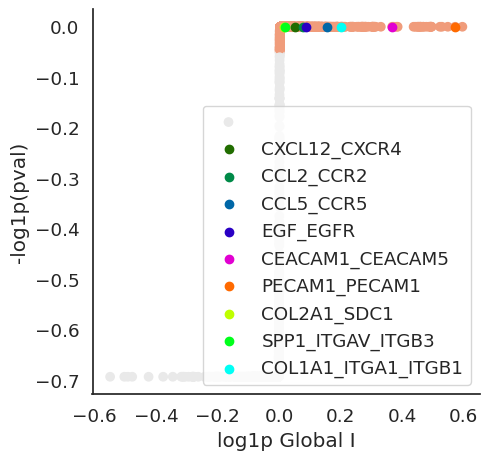

In [85]:
pl.global_plot(adata_impt_all, pairs=['CXCL12_CXCR4', "CCL2_CCR2", "CCL5_CCR5", 
                                      'EGF_EGFR', 'CEACAM1_CEACAM5', 'PECAM1_PECAM1',
                                      'COL2A1_SDC1', 'SPP1_ITGAV_ITGB3', 'COL1A1_ITGA1_ITGB1'], ## "SPP1_CD44", 
               figsize=(5,5), loc=4, cmap='RdGy_r', vmin=-1.5, vmax=2)

# plt.savefig('three_pair_subspot.pdf', dpi=300, bbox_inches='tight')

In [86]:
## CCL4_CCR8, ITGAL_ICAM1, SELPLG_SELL, HAVCR2_LGALS9
## Yes SELPLG_SELL
is_CD70_CD27_in = 'SPP1_CD44' in  adata_impt_all.uns["global_res"].index
print(f"is_CD70_CD27_in: {is_CD70_CD27_in}")

is_CD70_CD27_in: True


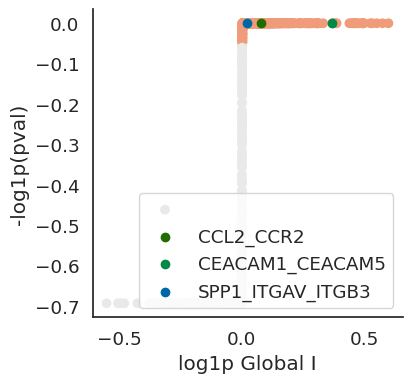

In [87]:
pl.global_plot(adata_impt_all, pairs=['CCL2_CCR2', 'CEACAM1_CEACAM5', 'SPP1_ITGAV_ITGB3'],    # 'CXCL12_CXCR4',
               figsize=(4,4), loc=4, cmap='RdGy_r', vmin=-1.5, vmax=2) 
# plt.savefig('three_pair_subspot.pdf', dpi=300, bbox_inches='tight')

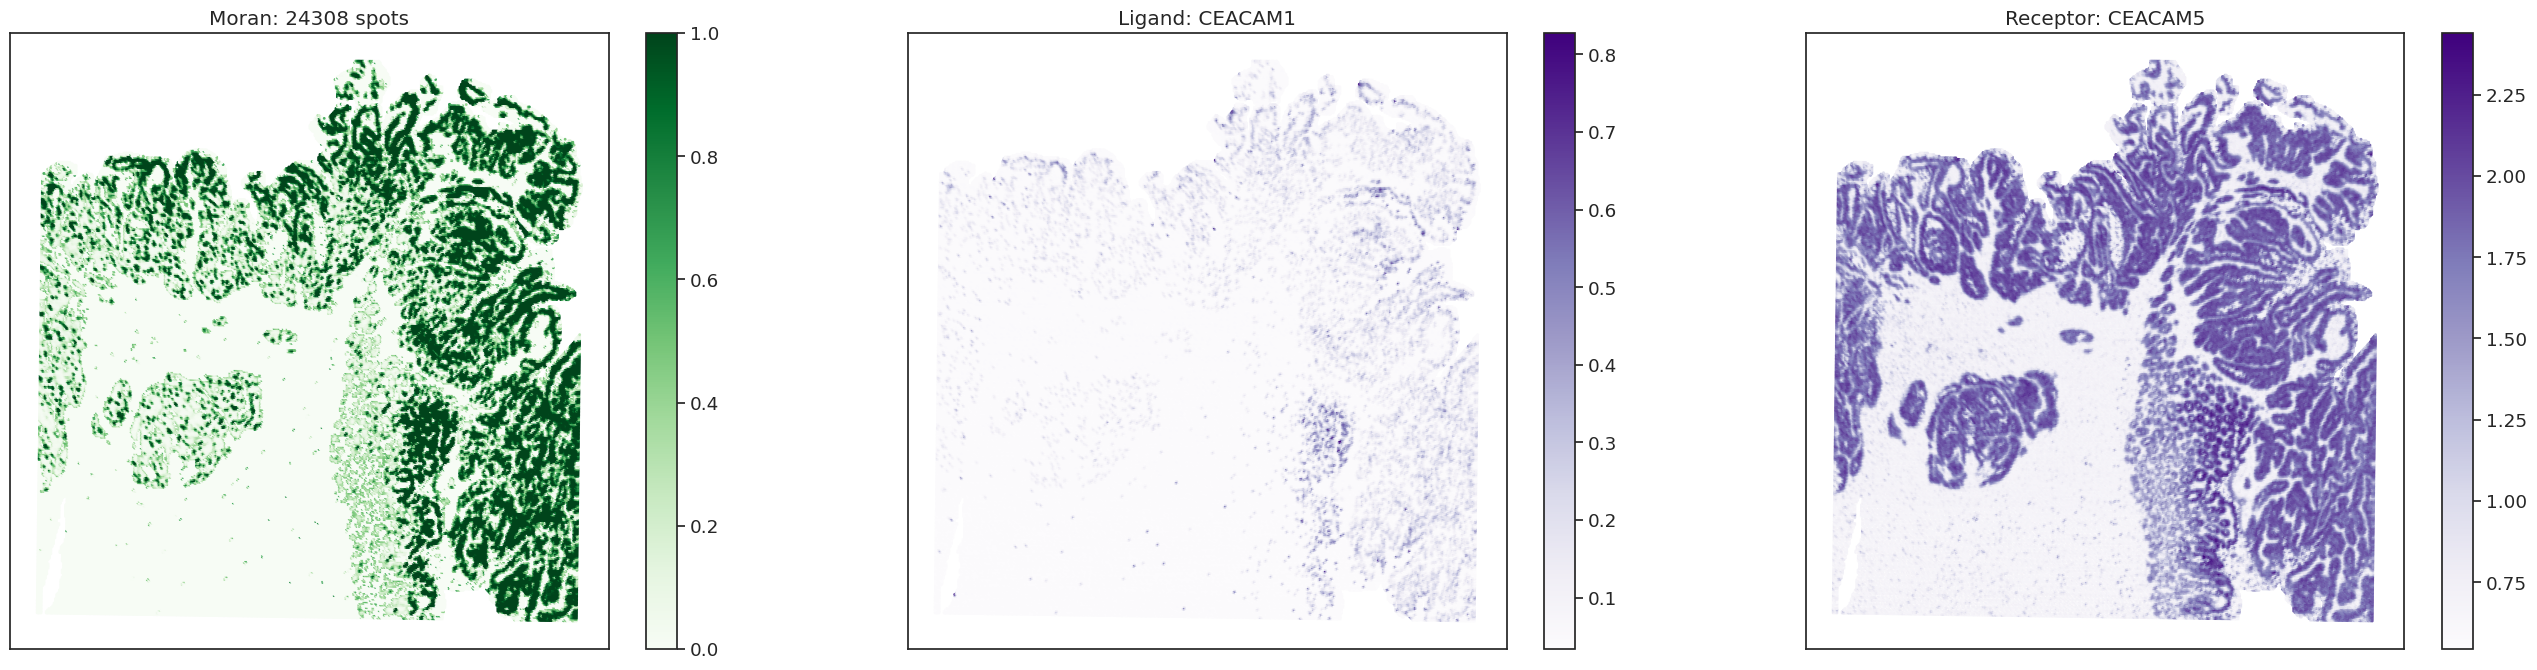

In [88]:
fstplt.plot_pairs_dot(adata_impt_all, ['CEACAM1_CEACAM5'], marker_size = 1)
# fstplt.plot_pairs_dot(adata_impt_all, ['CEACAM1_CEACAM5'], marker_size = 1, pdf="subspot_pair_CEACAM1_CEACAM5")

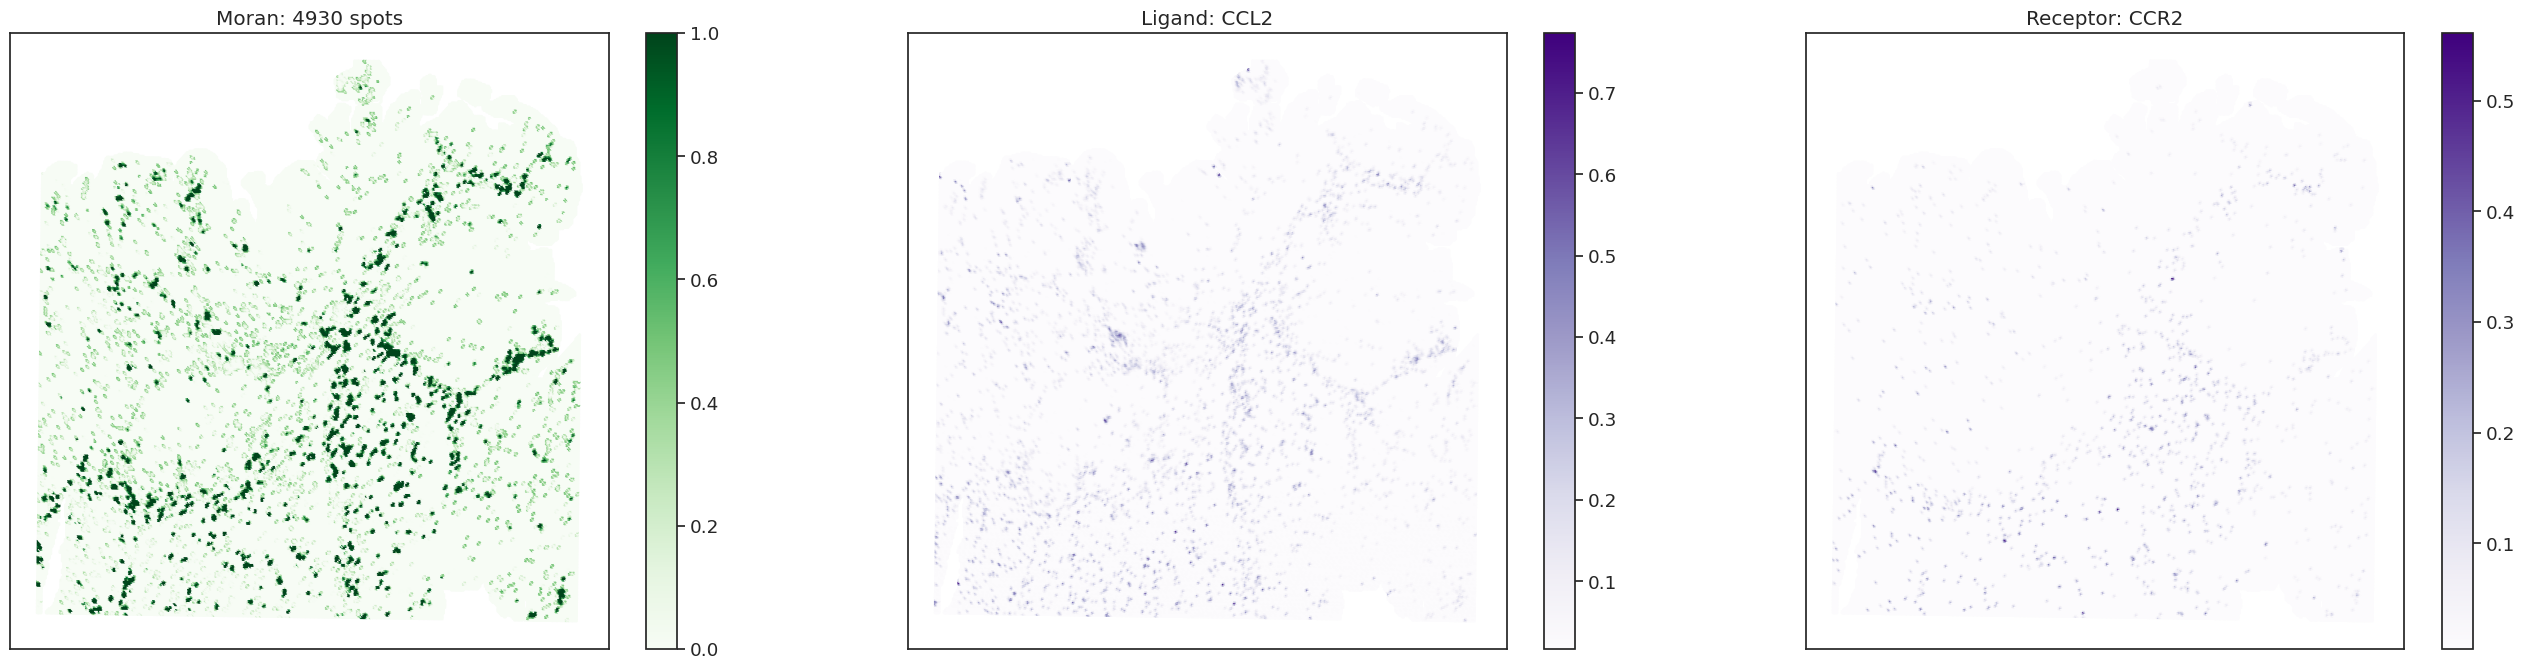

In [89]:
fstplt.plot_pairs_dot(adata_impt_all, ['CCL2_CCR2'], marker_size = 1)
# fstplt.plot_pairs_dot(adata_impt_all, ['CCL2_CCR2'], marker_size = 1, pdf="subspot_pair_CCL2_CCR2")

4.6 Local cell-cell communication pattern detection using SpatialAEH: continuous

In [90]:
bin_spots = (1-adata_impt_all.uns["local_z_p"])[adata_impt_all.uns['local_stat']['n_spots']>2]
print(bin_spots.shape[0], " pairs used for spatial clustering")
bin_spots

971  pairs used for spatial clustering


s_016um_00000_00000-1  s_016um_00000_00001-1  \
EFNA5_EPHA7                    0.0                    0.0   
EFNB1_EPHA4                    0.0                    0.0   
EFNB1_EPHB2                    0.0                    0.0   
EFNB1_EPHB3                    0.0                    0.0   
EFNB1_EPHB4                    0.0                    0.0   
...                            ...                    ...   
CCL5_CCR4                      0.0                    0.0   
CCL22_CCR4                     0.0                    0.0   
CCL17_CCR4                     0.0                    0.0   
CCL27_CCR3                     0.0                    0.0   
CORT_SSTR2                     0.0                    0.0   

             s_016um_00000_00002-1  s_016um_00000_00003-1  \
EFNA5_EPHA7                    0.0                    0.0   
EFNB1_EPHA4                    0.0                    0.0   
EFNB1_EPHB2                    0.0                    0.0   
EFNB1_EPHB3                    0.0                    0.0   
EFNB1_EPHB4                    0.0                    0.0   
...                            ...                    ...   
CCL5_CCR4                      0.0                    0.0   
CCL22_CCR4                     0.0                    0.0   
CCL17_CCR4                     0.0                    0.0   
CCL27_CCR3                     0.0                    0.0   
CORT_SSTR2                     0.0                    0.0   

             s_016um_00000_00007-1  s_016um_00000_00008-1  \
EFNA5_EPHA7                    0.0                    0.0   
EFNB1_EPHA4                    0.0                    0.0   
EFNB1_EPHB2                    0.0                    0.0   
EFNB1_EPHB3                    0.0                    0.0   
EFNB1_EPHB4                    0.0                    0.0   
...                            ...                    ...   
CCL5_CCR4                      0.0                    0.0   
CCL22_CCR4                     0.0                    0.0   
CCL17_CCR4                     0.0                    0.0   
CCL27_CCR3                     0.0                    0.0   
CORT_SSTR2                     0.0                    0.0   

             s_016um_00000_00009-1  s_016um_00000_00010-1  \
EFNA5_EPHA7                    0.0                    0.0   
EFNB1_EPHA4                    0.0                    0.0   
EFNB1_EPHB2                    0.0                    0.0   
EFNB1_EPHB3                    0.0                    0.0   
EFNB1_EPHB4                    0.0                    0.0   
...                            ...                    ...   
CCL5_CCR4                      0.0                    0.0   
CCL22_CCR4                     0.0                    0.0   
CCL17_CCR4                     0.0                    0.0   
CCL27_CCR3                     0.0                    0.0   
CORT_SSTR2                     0.0                    0.0   

             s_016um_00000_00011-1  s_016um_00000_00012-1  ...  \
EFNA5_EPHA7               0.000000               0.000000  ...   
EFNB1_EPHA4               0.000000               0.000000  ...   
EFNB1_EPHB2               0.000000               0.000000  ...   
EFNB1_EPHB3               0.000000               0.000000  ...   
EFNB1_EPHB4               0.000000               0.000000  ...   
...                            ...                    ...  ...   
CCL5_CCR4                 0.218871               0.019315  ...   
CCL22_CCR4                0.000000               0.000000  ...   
CCL17_CCR4                0.000000               0.000000  ...   
CCL27_CCR3                0.000000               0.000000  ...   
CORT_SSTR2                0.000000               0.000000  ...   

             s_016um_00385_00251-1  s_016um_00385_00252-1  \
EFNA5_EPHA7                    0.0                    0.0   
EFNB1_EPHA4                    0.0                    0.0   
EFNB1_EPHB2                    0.0                    0.0   
EFNB1_EPHB3                    0.0          

In [91]:
start = time.time()
gaussian_subspot = fst.MixedGaussian(spatial = adata_impt_all.obsm['spatial'],
                                 cov=None, group_size=16, d=5, kernel='laplacian', l=0.01)
print("--- %.3f seconds ---" %(time.time()-start))

--- 47.098 seconds ---


In [92]:
start = time.time()
gaussian_subspot.run_cluster(np.array(bin_spots.transpose()), 3, iter=50)
print("--- %.3f seconds ---" %(time.time()-start))

Iteration 0
updating variance
Iteration 1
--- 252.482 seconds ---


In [93]:
!pwd

/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/CRC16um


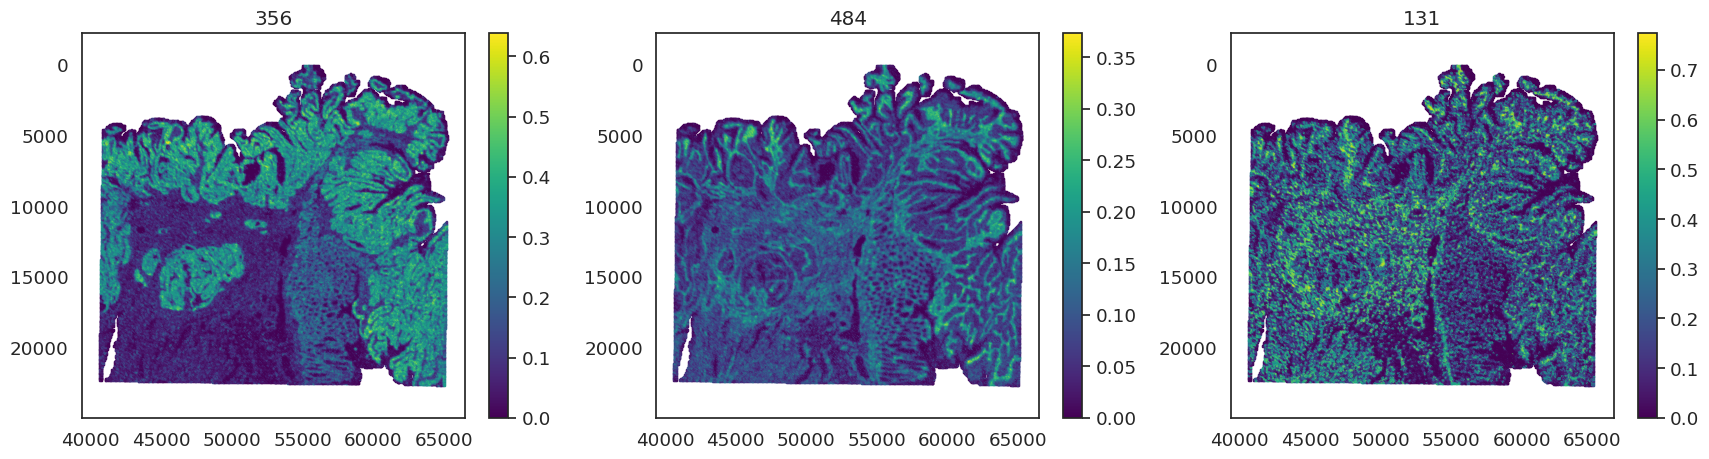

In [94]:
fstplt.sparseAEH_clusters(gaussian_subspot, w=3, s=0.5, save_path=None)
# fstplt.sparseAEH_clusters(gaussian_subspot, w=3, s=0.5, save_path="mel_DE_clusters_spot_pvalue_3patern.pdf")

4.7 Local cell-cell communication pattern detection using SpatialAEH: binary

In [95]:
bin_spots_binary = adata_impt_all.uns['selected_spots'].astype(int)[adata_impt_all.uns['local_stat']['n_spots']>2]
print(bin_spots_binary.shape[0], " pairs used for spatial clustering")
bin_spots_binary

971  pairs used for spatial clustering


s_016um_00000_00000-1  s_016um_00000_00001-1  \
EFNA5_EPHA7                      0                      0   
EFNB1_EPHA4                      0                      0   
EFNB1_EPHB2                      0                      0   
EFNB1_EPHB3                      0                      0   
EFNB1_EPHB4                      0                      0   
...                            ...                    ...   
CCL5_CCR4                        0                      0   
CCL22_CCR4                       0                      0   
CCL17_CCR4                       0                      0   
CCL27_CCR3                       0                      0   
CORT_SSTR2                       0                      0   

             s_016um_00000_00002-1  s_016um_00000_00003-1  \
EFNA5_EPHA7                      0                      0   
EFNB1_EPHA4                      0                      0   
EFNB1_EPHB2                      0                      0   
EFNB1_EPHB3                      0                      0   
EFNB1_EPHB4                      0                      0   
...                            ...                    ...   
CCL5_CCR4                        0                      0   
CCL22_CCR4                       0                      0   
CCL17_CCR4                       0                      0   
CCL27_CCR3                       0                      0   
CORT_SSTR2                       0                      0   

             s_016um_00000_00007-1  s_016um_00000_00008-1  \
EFNA5_EPHA7                      0                      0   
EFNB1_EPHA4                      0                      0   
EFNB1_EPHB2                      0                      0   
EFNB1_EPHB3                      0                      0   
EFNB1_EPHB4                      0                      0   
...                            ...                    ...   
CCL5_CCR4                        0                      0   
CCL22_CCR4                       0                      0   
CCL17_CCR4                       0                      0   
CCL27_CCR3                       0                      0   
CORT_SSTR2                       0                      0   

             s_016um_00000_00009-1  s_016um_00000_00010-1  \
EFNA5_EPHA7                      0                      0   
EFNB1_EPHA4                      0                      0   
EFNB1_EPHB2                      0                      0   
EFNB1_EPHB3                      0                      0   
EFNB1_EPHB4                      0                      0   
...                            ...                    ...   
CCL5_CCR4                        0                      0   
CCL22_CCR4                       0                      0   
CCL17_CCR4                       0                      0   
CCL27_CCR3                       0                      0   
CORT_SSTR2                       0                      0   

             s_016um_00000_00011-1  s_016um_00000_00012-1  ...  \
EFNA5_EPHA7                      0                      0  ...   
EFNB1_EPHA4                      0                      0  ...   
EFNB1_EPHB2                      0                      0  ...   
EFNB1_EPHB3                      0                      0  ...   
EFNB1_EPHB4                      0                      0  ...   
...                            ...                    ...  ...   
CCL5_CCR4                        0                      0  ...   
CCL22_CCR4                       0                      0  ...   
CCL17_CCR4                       0                      0  ...   
CCL27_CCR3                       0                      0  ...   
CORT_SSTR2                       0                      0  ...   

             s_016um_00385_00251-1  s_016um_00385_00252-1  \
EFNA5_EPHA7                      0                      0   
EFNB1_EPHA4                      0                      0   
EFNB1_EPHB2                      0                      0   
EFNB1_EPHB3                      0          

In [96]:
start = time.time()
gaussian_subspot_binary = fst.MixedGaussian(spatial = adata_impt_all.obsm['spatial'],
                                            cov=None, group_size=16, d=5, kernel='laplacian', l=0.01)
print("--- %.3f seconds ---" %(time.time()-start))

--- 43.366 seconds ---


In [97]:
start = time.time()
gaussian_subspot_binary.run_cluster(np.array(bin_spots_binary.transpose()), 3, iter=50)
print("--- %.3f seconds ---" %(time.time()-start))

Iteration 0
updating variance
Iteration 1
--- 259.325 seconds ---


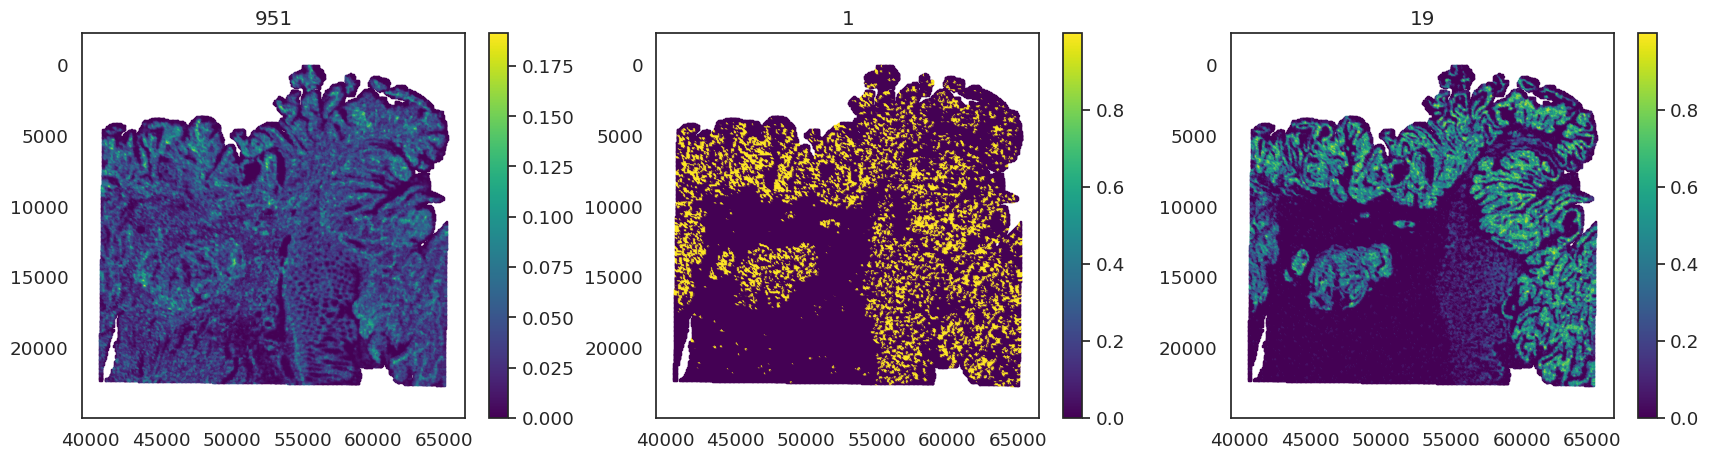

In [98]:
fstplt.sparseAEH_clusters(gaussian_subspot_binary, w=3, s=0.5, save_path=None)
# fstplt.sparseAEH_clusters(gaussian_subspot_binary, w=3, s=0.5, save_path="mel_DE_clusters_spot_pint_3patern.pdf")